# **Proyecto Hackathon The Data Guys**

    El siguiente notebook posee el análisis exploratorio de datos enfocado principalmente en la segmentación de clientes, para luego estudiar el comportamiento de cada segmento de cliente y con esto obtener recomendaciones que aumenten la dinámica de ventas para la empresa a futuro.

## Importación y carga

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from IPython.display import display

!pip install -q kaleido

import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Polygon


In [3]:
# df = pd.read_csv('Online_Retail.csv', encoding='ISO-8859-1')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/Online_Retail_2.csv', encoding='ISO-8859-1')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/Online_Retail_2.csv', encoding='ISO-8859-1')
#respaldo de df
# df_test =pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/Online_Retail_2.csv', encoding='ISO-8859-1')

## Exploración del Dataset

In [4]:
# Inspeccionar y visualizar datos

# Convertir todos los nombres de columnas a minúsculas
df.columns = df.columns.str.lower()

# Mostrar información general del DataFrame
print("\n 'Exploración del DF'\n")
display(df.info())

# Mostrar el número de valores nulos en cada columna
print("\n 'Valores Nulos'\n")
display(df.isnull().sum())

# Mostrar el número total de filas duplicadas
print("\n 'Valores Duplicados'\n")
display(df.duplicated().sum())

# Mostrar las primeras filas del DataFrame
print("\n\n 'Vista del DataFrame'\n")
display(df.head())


 'Exploración del DF'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   region        541909 non-null  object 
 8   continente    541909 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 37.2+ MB


None


 'Valores Nulos'



invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
region               0
continente           0
dtype: int64


 'Valores Duplicados'



5268



 'Vista del DataFrame'



invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

       invoice_date  unit_price  customer_id          region continente  
0  01/12/2019 08:26        2.55      17850.0  United Kingdom     Europa  
1  01/12/2019 08:26        3.39      17850.0  United Kingdom     Europa  
2  01/12/2019 08:26        2.75      17850.0  United Kingdom     Europa  
3  01/12/2019 08:26        3.39      17850.0  United Kingdom     Europa  
4  01/12/2019 08:26        3.39      17850.0  United Kingdom     Europa

## Preprocesamiento de los datos

In [5]:
# Manejar valores nulos en 'customer_id'
# Vamos a eliminar las filas sin customer_id, ya que no podemos hacer segmentación sin esta información
df = df.dropna(subset=['customer_id'])

# Verificar valores nulos nuevamente
print("\n Valores nulos actualizados\n")
print(df.isnull().sum())
print("\n")

# Eliminar duplicados
df = df.drop_duplicates()

# Verificar duplicados nuevamente
duplicados = df.duplicated().sum()
print(f"Filas duplicadas después de la eliminación: {duplicados}")


 Valores nulos actualizados

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
region          0
continente      0
dtype: int64


Filas duplicadas después de la eliminación: 0


In [6]:
# Convertir 'invoice_date' a datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")

# Verificar el tipo de dato de 'invoice_date'
print(df['invoice_date'].dtype)

datetime64[ns]


In [7]:
df.describe()

quantity                   invoice_date     unit_price  \
count  401604.000000                         401604  401604.000000   
mean       12.183273  2020-07-10 08:03:59.659963904       3.474064   
min    -80995.000000            2019-12-01 08:26:00       0.000000   
25%         2.000000            2020-04-06 15:02:00       1.250000   
50%         5.000000            2020-07-29 15:40:00       1.950000   
75%        12.000000            2020-10-20 11:58:30       3.750000   
max     80995.000000            2020-12-09 12:50:00   38970.000000   
std       250.283037                            NaN      69.764035   

         customer_id  
count  401604.000000  
mean    15281.160818  
min     12346.000000  
25%     13939.000000  
50%     15145.000000  
75%     16784.000000  
max     18287.000000  
std      1714.006089

In [8]:
# Eliminar registros con cantidad o precio unitario negativos
df = df[(df['quantity'] > 0) & (df['unit_price'] > 0)]

# Verificar el rango de 'quantity' y 'unit_price'
df[['quantity', 'unit_price']].describe()

quantity     unit_price
count  392692.000000  392692.000000
mean       13.119702       3.125914
std       180.492832      22.241836
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000

Estadísticas de quantity y unit_price:

La cantidad media de artículos por orden es de 13.12, pero con una desviación estándar alta (180.49), lo que indica una gran variabilidad.
El precio unitario medio es de 3.13, pero también con alta variabilidad (desviación estándar de 22.24).
Hay algunos valores extremos, con un máximo de 80,995 para quantity y 8,142.75 para unit_price.

### Análisis RFM

In [9]:
# Primero, asegurémonos de que 'customer_id' sea de tipo entero
df['customer_id'] = df['customer_id'].astype(int)

# Calcular el valor monetario total por transacción
df['total_price'] = df['quantity'] * df['unit_price']

# Encontrar la fecha más reciente en el dataset
max_date = df['invoice_date'].max()

# Calcular RFM
rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (max_date - x.max()).days,  # Recency
    'invoice_no': 'count',  # Frequency
    'total_price': 'sum'  # Monetary
})

# Renombrar las columnas
rfm.columns = ['recency', 'frequency', 'monetary']

# Asegurarse de que 'monetary' no tenga valores negativos
rfm = rfm[rfm['monetary'] > 0]

# Mostrar las primeras filas del dataframe RFM
display(rfm.head())

# Mostrar estadísticas descriptivas del dataframe RFM
display(rfm.describe())

# Verificar si hay valores nulos en el dataframe RFM
rfm.isnull().sum()

recency  frequency  monetary
customer_id                              
12346            326          1  77183.60
12347              1        182   4310.00
12348             74         31   1797.24
12349             18         73   1757.55
12350            310         17    334.40

recency    frequency       monetary
count  4338.000000  4338.000000    4338.000000
mean     91.610650    90.523744    2048.688081
std     100.191727   225.506968    8985.230220
min       0.000000     1.000000       3.750000
25%      17.000000    17.000000     306.482500
50%      50.000000    41.000000     668.570000
75%     141.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000

recency      0
frequency    0
monetary     0
dtype: int64


**Estadísticas RFM:**

- Recency: La media es de 91.61 días, con un mínimo de 0 y un máximo de 374 días.
- Frequency: En promedio, los clientes han realizado 90.52 compras, pero hay una gran variabilidad (desviación estándar de 225.51).
- Monetary: El gasto promedio por cliente es de 2,048.69, pero con una desviación estándar muy alta (8,985.23), indicando una gran dispersión en el gasto.

No hay valores nulos en las métricas RFM, lo cual es bueno para el análisis.

In [10]:
!pip show seaborn

Name: seaborn
Version: 0.13.1
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, pandas
Required-by: missingno


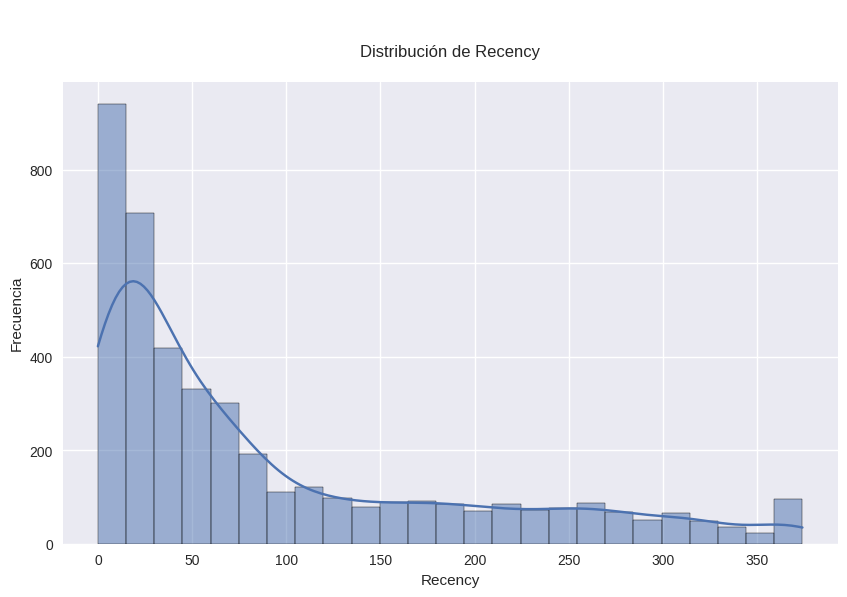

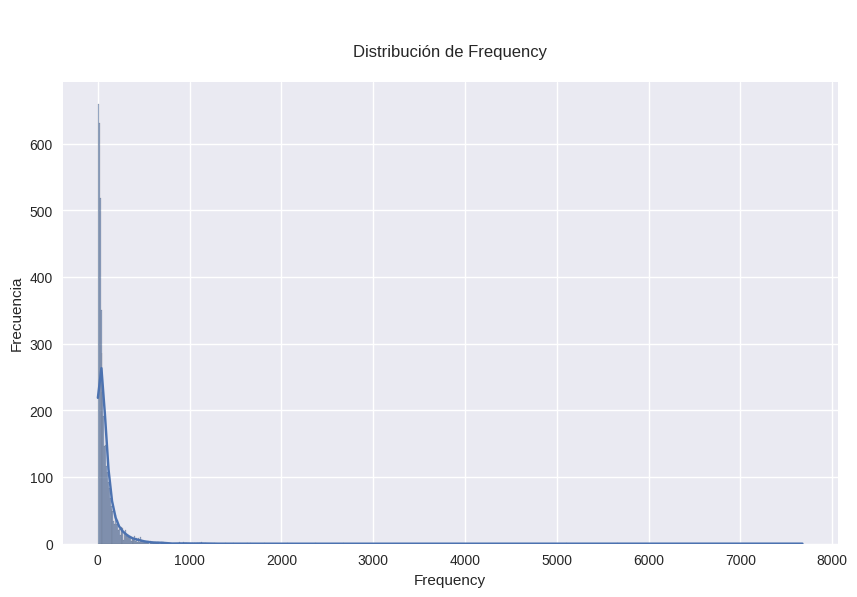

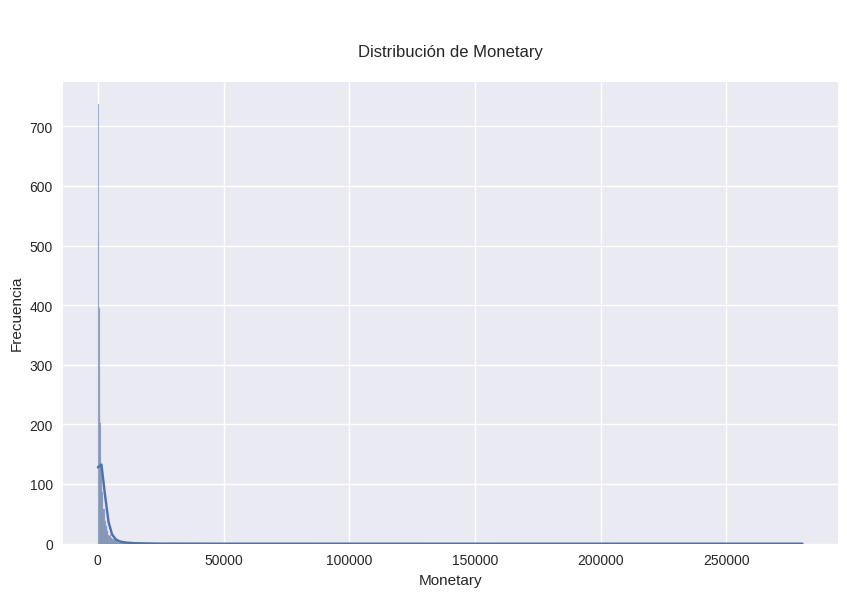

In [11]:
# Configurar el estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
# Función para crear histogramas
def plot_distribution(dataframe, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataframe, x=column, kde=True)
    plt.title(f'\n\nDistribución de {column.capitalize()}\n')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frecuencia')
    plt.show()

# Crear histogramas para cada métrica RFM
for column in ['recency', 'frequency', 'monetary']:
    plot_distribution(rfm, column)

- Distribución de Recency:

La gráfica muestra una distribución asimétrica positiva (cola hacia la derecha).
Hay una alta concentración de clientes con recency baja (cerca de 0), lo que indica que muchos clientes han realizado compras recientemente.
Hay una cola larga hacia la derecha, lo que sugiere que algunos clientes no han comprado en mucho tiempo.

- Distribución de Frequency:

Muestra una distribución extremadamente asimétrica positiva (cola larga a la derecha).
La gran mayoría de los clientes tienen una frecuencia de compra baja (cerca de 0).
Hay unos pocos clientes con frecuencias de compra muy altas (hasta 7k+).


- Distribución de Monetary:

También presenta una distribución muy asimétrica positiva.
La mayoría de los clientes tienen un valor monetario bajo.
Hay algunos clientes con valores monetarios extremadamente altos (hasta 250,000+).

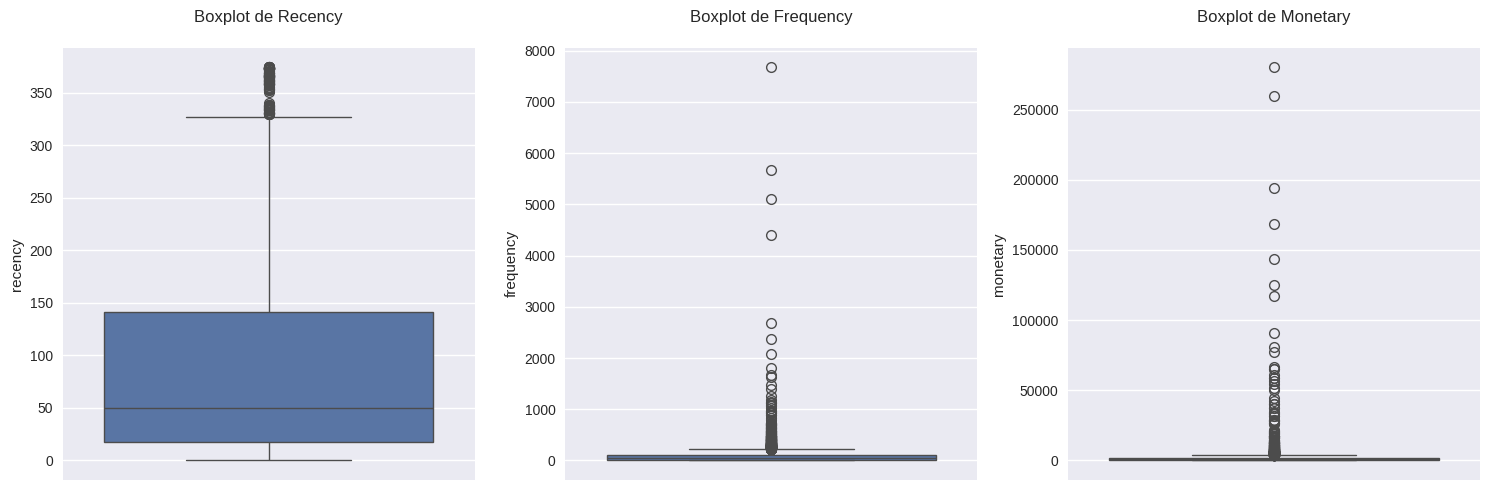

In [12]:
# Boxplots para cada métrica RFM
plt.figure(figsize=(15, 5))
for i, column in enumerate(['recency', 'frequency', 'monetary'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=rfm[column])
    plt.title(f'Boxplot de {column.capitalize()}\n')
plt.tight_layout()
plt.show()

In [13]:
# Para cada métrica RFM
for column in ['recency', 'frequency', 'monetary']:
    print(f"\n\nEstadísticas para {column.capitalize()}:\n")
    stats = rfm[column].describe(percentiles=[.25, .5, .75])
    print(stats)

    # Cálculo del IQR y límites para outliers
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Límite inferior para outliers: {lower_bound}")
    print(f"Límite superior para outliers: {upper_bound}")
    print(f"Número de outliers inferiores: {sum(rfm[column] < lower_bound)}")
    print(f"Número de outliers superiores: {sum(rfm[column] > upper_bound)}")



Estadísticas para Recency:

count    4338.000000
mean       91.610650
std       100.191727
min         0.000000
25%        17.000000
50%        50.000000
75%       141.000000
max       374.000000
Name: recency, dtype: float64
Límite inferior para outliers: -169.0
Límite superior para outliers: 327.0
Número de outliers inferiores: 0
Número de outliers superiores: 155


Estadísticas para Frequency:

count    4338.000000
mean       90.523744
std       225.506968
min         1.000000
25%        17.000000
50%        41.000000
75%        98.000000
max      7676.000000
Name: frequency, dtype: float64
Límite inferior para outliers: -104.5
Límite superior para outliers: 219.5
Número de outliers inferiores: 0
Número de outliers superiores: 381


Estadísticas para Monetary:

count      4338.000000
mean       2048.688081
std        8985.230220
min           3.750000
25%         306.482500
50%         668.570000
75%        1660.597500
max      280206.020000
Name: monetary, dtype: float64
Límite i

### Observaciones RFM

**Recency**
   - La recencia media es de 91.61 días, con una mediana de 50 días.
   - El 75% de los clientes han comprado en los últimos 141 días.
   - Hay 155 clientes (3.57%) considerados outliers superiores, que no han comprado en más de 327 días.
   - La distribución es asimétrica positiva (media > mediana), lo que indica una cola larga hacia la derecha.

**Frequency**
   - La frecuencia media de compra es 90.52, pero la mediana es solo 41, indicando una fuerte asimetría positiva.
   - El 75% de los clientes han realizado 98 o menos compras.
   - Hay 381 clientes (8.78%) considerados outliers superiores, con más de 219.5 compras.
   - El máximo de 7676 compras sugiere la presencia de algunos clientes extremadamente frecuentes.

**Monetary**
   - El valor monetario medio es de 2048.69, pero la mediana es solo 668.57, indicando una fuerte asimetría positiva.
   - El 75% de los clientes han gastado 1660.60 o menos.
   - Hay 425 clientes (9.80%) considerados outliers superiores, gastando más de 3691.77.
   - El máximo de 280,206.02 sugiere la presencia de algunos clientes de muy alto valor.

### Conclusiones y recomendaciones:

- **Asimetría**: Todas las métricas muestran una fuerte asimetría positiva, especialmente Frequency y Monetary. Esto refuerza la necesidad de una transformación logarítmica antes del clustering.

- **Outliers**: Hay un número significativo de outliers superiores en todas las métricas, especialmente en Frequency y Monetary. Estos representan clientes de alto valor que merecen un análisis y tratamiento especial.

- **Segmentación**: La gran diferencia entre la media y la mediana en Frequency y Monetary sugiere que **una pequeña proporción de clientes contribuye significativamente al negocio**. Una segmentación efectiva podría ayudar a identificar y manejar estos grupos de manera diferenciada.

- **Estrategias diferenciadas**:
   - Para clientes con alta recencia (>327 días), considerar campañas de reactivación.
   - Para los outliers superiores en Frequency y Monetary, desarrollar programas de fidelización y retención especiales.
   - Para la mayoría de los clientes (que están por debajo de la mediana en Frequency y Monetary), diseñar estrategias para aumentar su frecuencia de compra y valor.


- **Preparación para clustering**:
   - Aplicar transformación logarítmica a Frequency y Monetary.
   - Normalizar todas las variables.
   - Al interpretar los resultados del clustering, prestar especial atención a cómo se agrupan los outliers.


Outliers en recency:
Número de outliers: 155
Límite inferior: -169.0
Límite superior: 327.0


recency  frequency  monetary
customer_id                              
12386            338         10    401.90
12441            367         11    173.55
12489            336         15    334.93
12501            337        149   2169.39
12515            353         16    383.70


Outliers en frequency:
Número de outliers: 381
Límite inferior: -104.5
Límite superior: 219.5


recency  frequency   monetary
customer_id                               
12359             57        245    6310.03
12362              2        266    5226.23
12415             23        714  124914.53
12428             25        294    7956.46
12431             35        234    6419.95


Outliers en monetary:
Número de outliers: 425
Límite inferior: -1724.6899999999996
Límite superior: 3691.7699999999995


recency  frequency  monetary
customer_id                              
12346            326          1  77183.60
12347              1        182   4310.00
12357             32        131   6207.67
12359             57        245   6310.03
12362              2        266   5226.23


Outliers extremos en recency
Número de outliers extremos: 0


Empty DataFrame
Columns: [recency, frequency, monetary]
Index: []


Outliers extremos en frequency
Número de outliers extremos: 179


recency  frequency   monetary
customer_id                               
12415             23        714  124914.53
12433              0        420   13375.87
12451             10        354    9035.52
12471              1        459   19788.65
12474             16        422    7324.09


Outliers extremos en monetary
Número de outliers extremos: 222


recency  frequency   monetary
customer_id                               
12346            326          1   77183.60
12357             32        131    6207.67
12359             57        245    6310.03
12409             78        109   11072.67
12415             23        714  124914.53

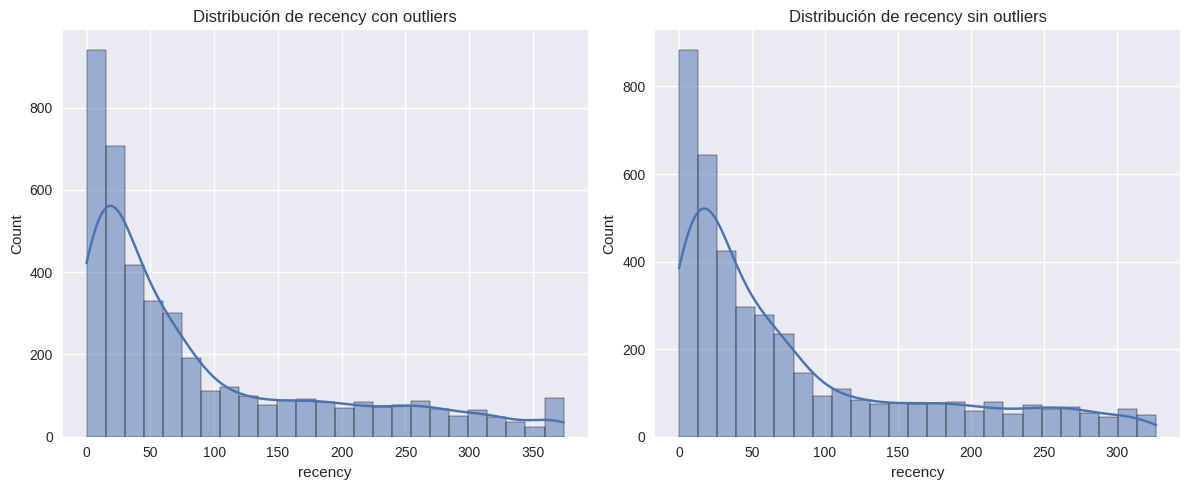

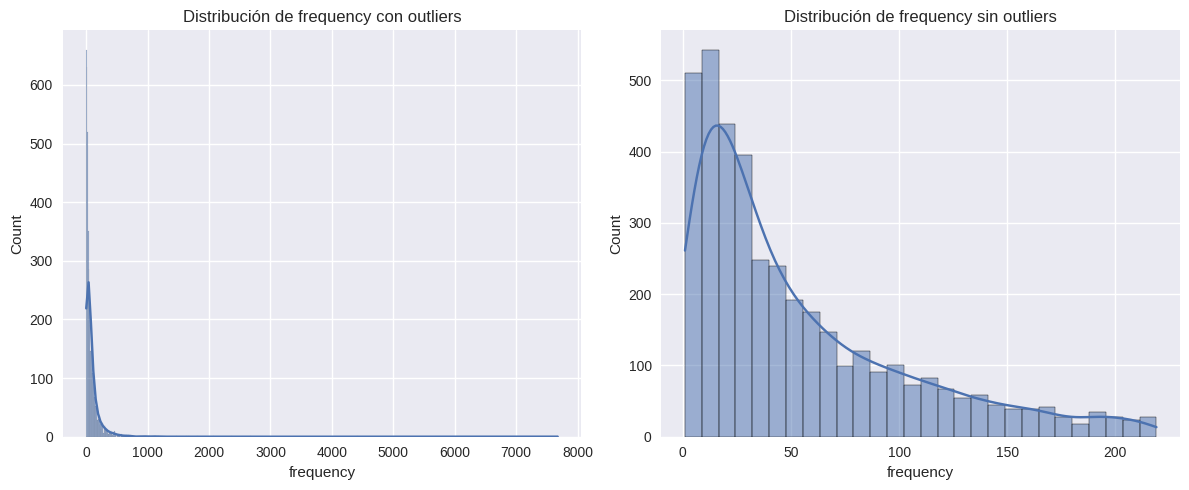

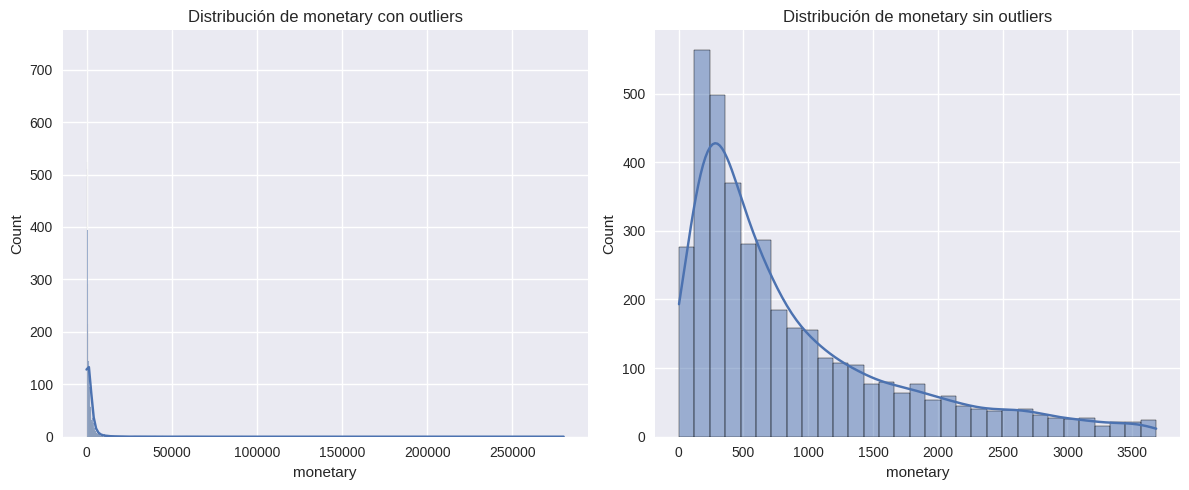

In [14]:
def identify_outliers(df, column):
    # Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Calcular el Rango Intercuartílico (IQR)
    IQR = Q3 - Q1
    # Definir los límites para los outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identificar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Identificar outliers para cada columna RFM
for column in ['recency', 'frequency', 'monetary']:
    outliers, lower, upper = identify_outliers(rfm, column)
    print(f"\nOutliers en {column}:")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Límite inferior: {lower}")
    print(f"Límite superior: {upper}")
    display(outliers.head())

def extreme_outliers(df, column, factor=3):
    # Similar a identify_outliers, pero con un factor más extremo
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    extremes = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return extremes

# Identificar outliers extremos para cada columna RFM
for column in ['recency', 'frequency', 'monetary']:
    extremes = extreme_outliers(rfm, column)
    print(f"\nOutliers extremos en {column}")
    print(f"Número de outliers extremos: {len(extremes)}")
    display(extremes.head())

def plot_distribution_with_without_outliers(df, column):
    # Identificar outliers
    outliers, lower, upper = identify_outliers(df, column)
    # Crear un DataFrame sin outliers
    non_outliers = df[(df[column] >= lower) & (df[column] <= upper)]

    # Crear una figura con dos subplots
    plt.figure(figsize=(12, 5))

    # Subplot para la distribución con outliers
    plt.subplot(121)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribución de {column} con outliers')

    # Subplot para la distribución sin outliers
    plt.subplot(122)
    sns.histplot(non_outliers[column], kde=True)
    plt.title(f'Distribución de {column} sin outliers')

    plt.tight_layout()
    plt.show()

# Visualizar la distribución con y sin outliers para cada columna RFM
for column in ['recency', 'frequency', 'monetary']:
    plot_distribution_with_without_outliers(rfm, column)

### Distribuciones sin Outliers en Frequency y Monetary



Tamaño del DataFrame rfm actualizado: 3662

Estadísticas descriptivas del rfm actualizado:



recency    frequency     monetary
count  3662.000000  3662.000000  3662.000000
mean    103.790279    45.593119   796.690121
std     103.034756    40.241099   750.029262
min       0.000000     1.000000     3.750000
25%      23.000000    15.000000   261.975000
50%      63.000000    31.000000   528.885000
75%     169.000000    66.000000  1071.375000
max     374.000000   172.000000  3683.860000

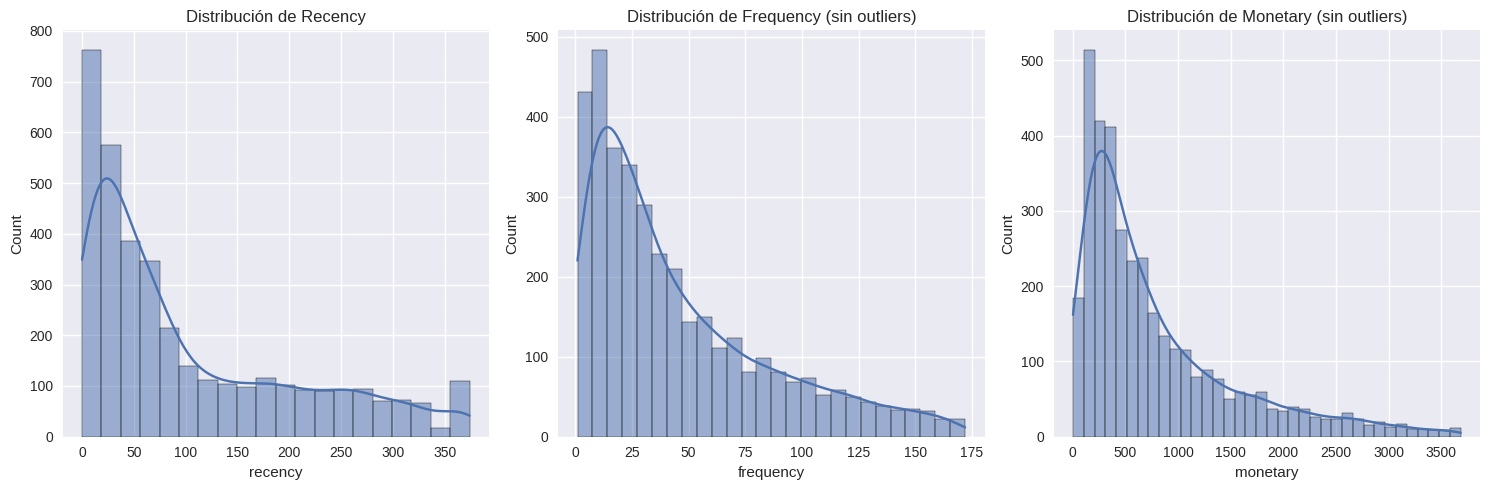

In [15]:
# Función para remover outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

# Actualizar rfm eliminando outliers de 'monetary' y 'frequency'
rfm = remove_outliers(rfm, ['monetary', 'frequency'])

# Imprimir información sobre el nuevo DataFrame
print("\n")
print(f"Tamaño del DataFrame rfm actualizado: {len(rfm)}")
print("\nEstadísticas descriptivas del rfm actualizado:\n")
display(rfm.describe())

plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(data=rfm, x='recency', kde=True)
plt.title('Distribución de Recency')

plt.subplot(132)
sns.histplot(data=rfm, x='frequency', kde=True)
plt.title('Distribución de Frequency (sin outliers)')

plt.subplot(133)
sns.histplot(data=rfm, x='monetary', kde=True)
plt.title('Distribución de Monetary (sin outliers)')

plt.tight_layout()
plt.show()

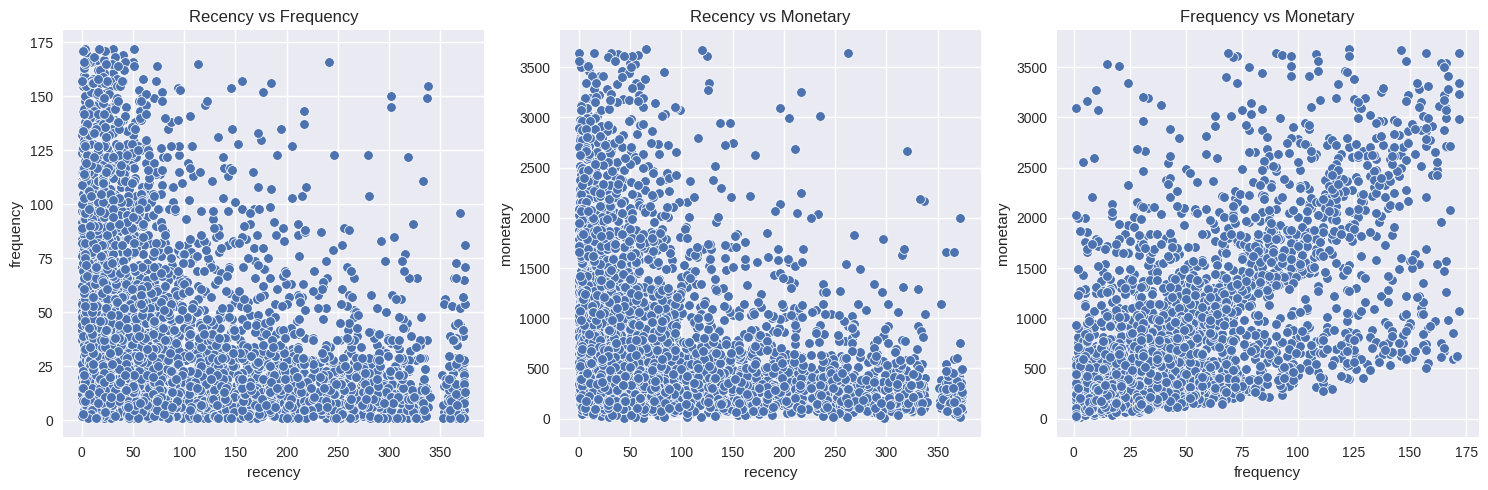

In [16]:
# Scatter plots para visualizar relaciones entre métricas
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.scatterplot(data=rfm, x='recency', y='frequency')
plt.title('Recency vs Frequency')
plt.subplot(132)
sns.scatterplot(data=rfm, x='recency', y='monetary')
plt.title('Recency vs Monetary')
plt.subplot(133)
sns.scatterplot(data=rfm, x='frequency', y='monetary')
plt.title('Frequency vs Monetary')
plt.tight_layout()
plt.show()

- **Recency vs Frequency**: Muestra una concentración de puntos en la esquina inferior izquierda, indicando que muchos clientes tienen baja recencia y baja frecuencia. Hay algunos outliers con frecuencia muy alta.
- **Recency vs Monetary**: Similar al anterior, con la mayoría de los puntos concentrados en valores bajos, pero con algunos outliers de alto valor monetario.
- **Frequency vs Monetary**: Muestra una relación positiva más clara, con algunos clientes destacando por tener valores muy altos en ambas métricas.


Matriz de correlación:



recency  frequency  monetary
recency    1.000000  -0.351372 -0.327549
frequency -0.351372   1.000000  0.673326
monetary  -0.327549   0.673326  1.000000



Relación entre Recency y Frequency:


Correlación: -0.3514
Covarianza: -1456.8712
Recency - Media: 103.7903, Desviación estándar: 103.0348
Frequency - Media: 45.5931, Desviación estándar: 40.2411


Relación entre Recency y Monetary:


Correlación: -0.3275
Covarianza: -25312.6626
Recency - Media: 103.7903, Desviación estándar: 103.0348
Monetary - Media: 796.6901, Desviación estándar: 750.0293


Relación entre Frequency y Monetary:


Correlación: 0.6733
Covarianza: 20322.3175
Frequency - Media: 45.5931, Desviación estándar: 40.2411
Monetary - Media: 796.6901, Desviación estándar: 750.0293




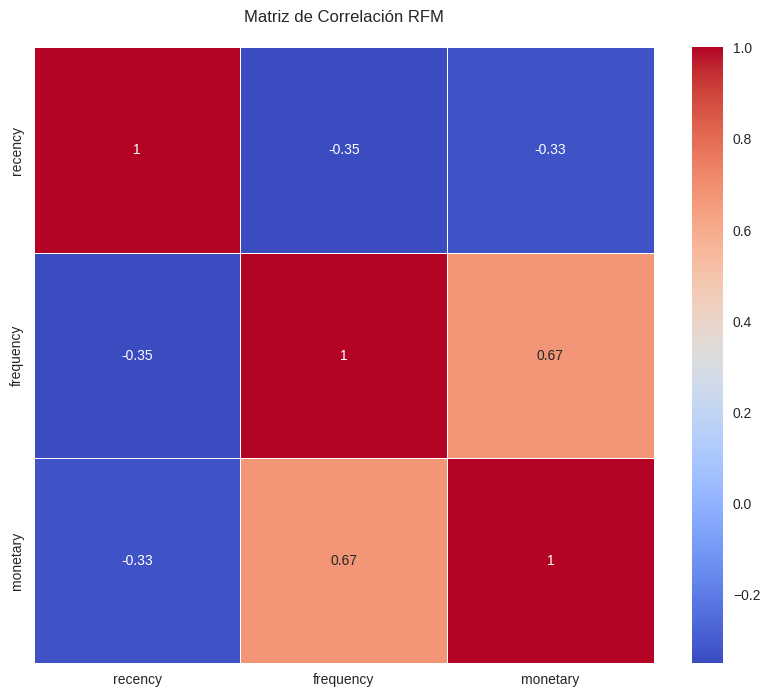

In [17]:
# Calcular la matriz de correlación
corr_matrix = rfm[['recency', 'frequency', 'monetary']].corr()

print("\nMatriz de correlación:\n")
display(corr_matrix)
print("\n")

# Función para describir la relación entre dos variables
def describe_relationship(x, y, x_name, y_name):
    print(f"Relación entre {x_name} y {y_name}:")
    print("\n")
    print(f"Correlación: {x.corr(y):.4f}")
    print(f"Covarianza: {x.cov(y):.4f}")
    print(f"{x_name} - Media: {x.mean():.4f}, Desviación estándar: {x.std():.4f}")
    print(f"{y_name} - Media: {y.mean():.4f}, Desviación estándar: {y.std():.4f}")
    print("\n")

# Describir las relaciones
describe_relationship(rfm['recency'], rfm['frequency'], 'Recency', 'Frequency')
describe_relationship(rfm['recency'], rfm['monetary'], 'Recency', 'Monetary')
describe_relationship(rfm['frequency'], rfm['monetary'], 'Frequency', 'Monetary')

# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación RFM\n')
plt.show()

**Recency y Frequency:**
- -La correlación es negativa (-0.3514), lo que indica que a medida que la Recency aumenta, la Frequency tiende a disminuir, y viceversa. Esto podría sugerir que los clientes que han comprado más recientemente tienden a hacer compras con menos frecuencia.

**Recency y Monetary:**
- La correlación también es negativa (-0.3275), lo que sugiere que los clientes que han comprado más recientemente tienden a gastar menos, y viceversa. Esto podría indicar que los clientes que gastan más tienden a hacerlo en compras menos frecuentes.

**Frequency y Monetary:**
- La correlación es positiva (0.6733), lo que indica que a medida que la Frequency aumenta, la Monetary también tiende a aumentar. Esto sugiere que los clientes que hacen compras con más frecuencia también tienden a gastar más en total.

Estas son solo observaciones generales y podrían no aplicarse a todos los clientes. También es importante tener en cuenta otros factores que podrían influir en estas relaciones.

In [18]:
# Estadísticas descriptivas
display(rfm.describe())

# Asimetría y curtosis
print("\nAsimetría:")
print(rfm.skew())
print("\nCurtosis:")
print(rfm.kurtosis())

recency    frequency     monetary
count  3662.000000  3662.000000  3662.000000
mean    103.790279    45.593119   796.690121
std     103.034756    40.241099   750.029262
min       0.000000     1.000000     3.750000
25%      23.000000    15.000000   261.975000
50%      63.000000    31.000000   528.885000
75%     169.000000    66.000000  1071.375000
max     374.000000   172.000000  3683.860000


Asimetría:
recency      1.063685
frequency    1.153950
monetary     1.553947
dtype: float64

Curtosis:
recency     -0.037111
frequency    0.531266
monetary     1.989756
dtype: float64


- La **asimetría** es una medida de la falta de simetría en la distribución de los datos. Un valor de asimetría **positivo** indica una distribución con cola a la derecha o sesgada a la derecha.

- La **curtosis** es una medida de la **pesadez** de las colas de una distribución. En comparación con una distribución normal, un valor de curtosis positivo indica colas más pesadas (más propensas a tener valores extremos), mientras que un valor negativo indica colas más ligeras (menos propensas a tener valores extremos).

### Segmentación de clientes (Clustering)

In [19]:
# Aplicar transformación logarítmica
rfm['log_frequency'] = np.log1p(rfm['frequency'])
rfm['log_monetary'] = np.log1p(rfm['monetary'])

In [20]:
# Crear un nuevo DataFrame con las variables transformadas
rfm_normalized = rfm[['recency', 'log_frequency', 'log_monetary']].copy()

# Normalizar las variables
scaler = StandardScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_normalized),
                              columns=['recency', 'log_frequency', 'log_monetary'],
                              index=rfm.index)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

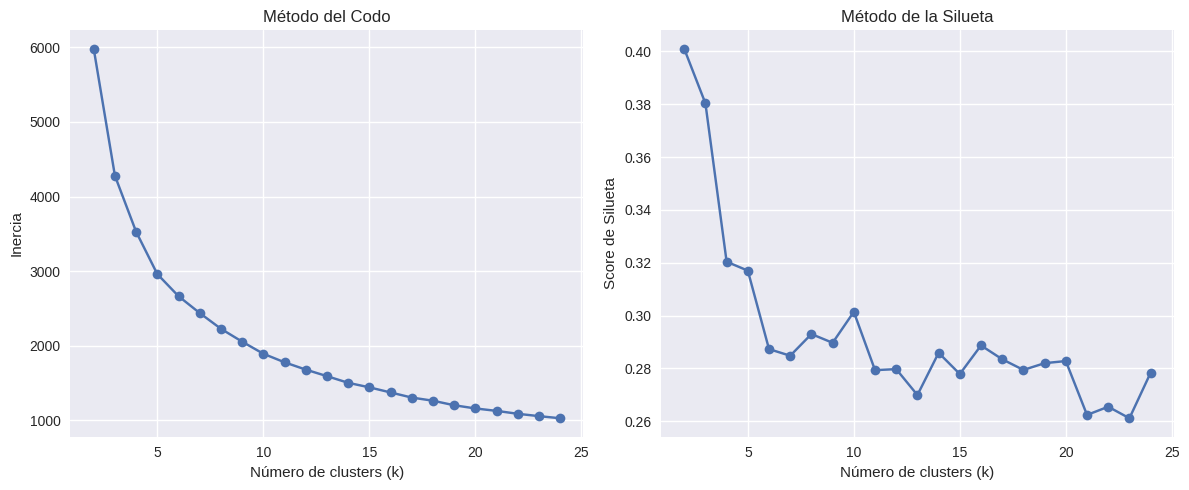

In [21]:
# Función para calcular la inercia (suma de las distancias al cuadrado)
def calculate_inertia(data, k_range):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    return inertias

# Función para calcular el score de silueta
def calculate_silhouette(data, k_range):
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    return silhouette_scores

# Rango de número de clusters a probar
k_range = range(2, 25)

# Calcular inercia y score de silueta
inertias = calculate_inertia(rfm_normalized, k_range)
silhouette_scores = calculate_silhouette(rfm_normalized, k_range)

# Visualizar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(122)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Score de Silueta')
plt.title('Método de la Silueta')

plt.tight_layout()
plt.show()


**Número óptimo de clusters**

El gráfico del método del codo muestra una disminución pronunciada de la inercia hasta aproximadamente 4-5 clusters, después de lo cual la disminución se vuelve más gradual. El gráfico del score de silueta muestra valores más altos para números menores de clusters, con un pico local alrededor de 4-5 clusters. Por lo que estableceremos optimal_k = 5.

In [22]:
# Número óptimo de clusters
optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Añadir los clusters al DataFrame original
rfm_with_clusters = rfm.copy()
rfm_with_clusters['Cluster'] = rfm['Cluster']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Estadísticas por cluster



recency  frequency     monetary  count
Cluster                                           
0        240.772313  36.134791   563.934827    549
1        278.420792   8.497525   191.928688    404
2         67.638047  10.533670   226.333771    594
3         48.617121  36.756350   601.511207   1063
4         41.403992  93.500000  1669.668385   1052

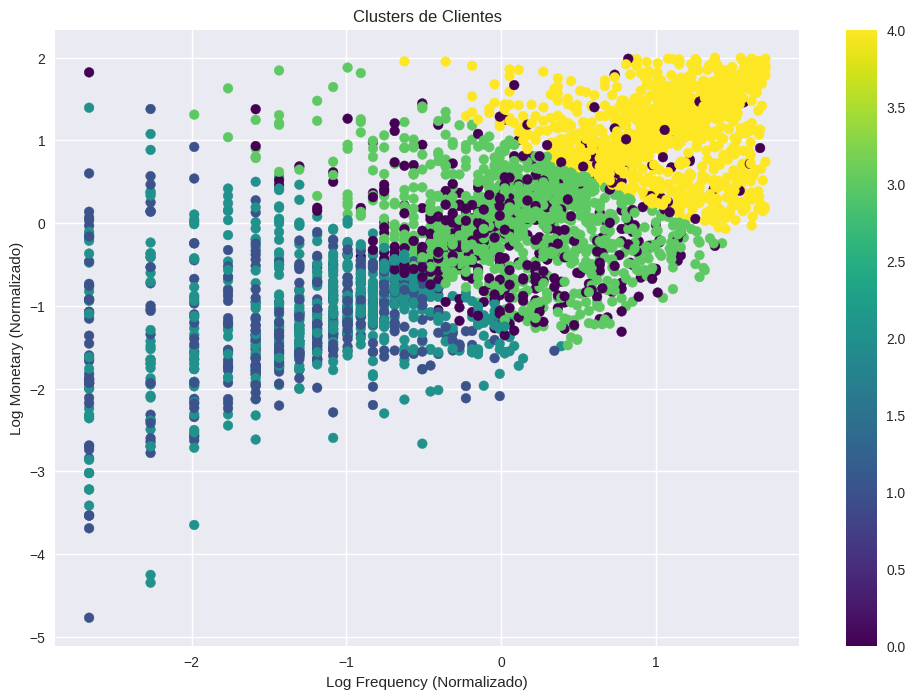

In [23]:
# Estadísticas descriptivas por cluster
cluster_stats = rfm_with_clusters.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
})

# Añadir el conteo de clientes por cluster
cluster_stats['count'] = rfm_with_clusters.groupby('Cluster').size()

print("\nEstadísticas por cluster\n")
display(cluster_stats)

# Visualizar los clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(rfm_normalized['log_frequency'],
                      rfm_normalized['log_monetary'],
                      c=rfm['Cluster'],
                      cmap='viridis')
plt.xlabel('Log Frequency (Normalizado)')
plt.ylabel('Log Monetary (Normalizado)')
plt.title('Clusters de Clientes')
plt.colorbar(scatter)
plt.show()

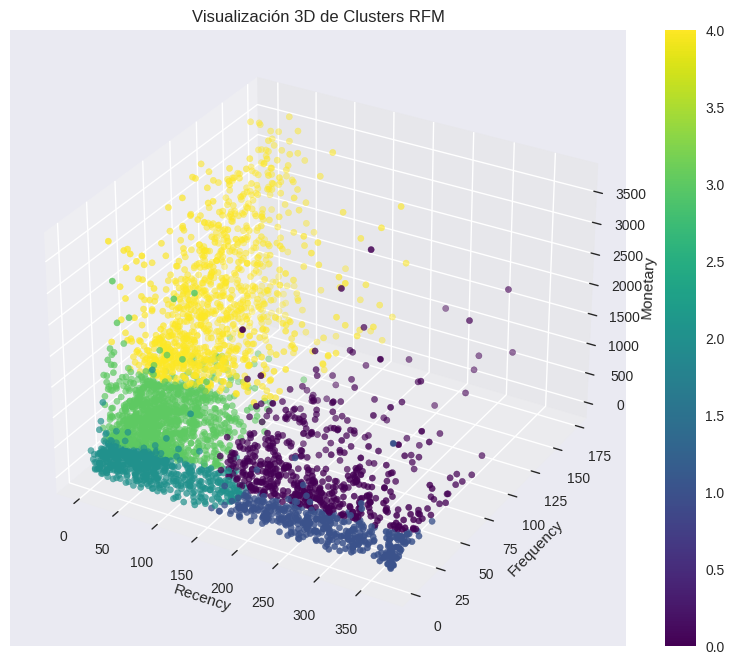

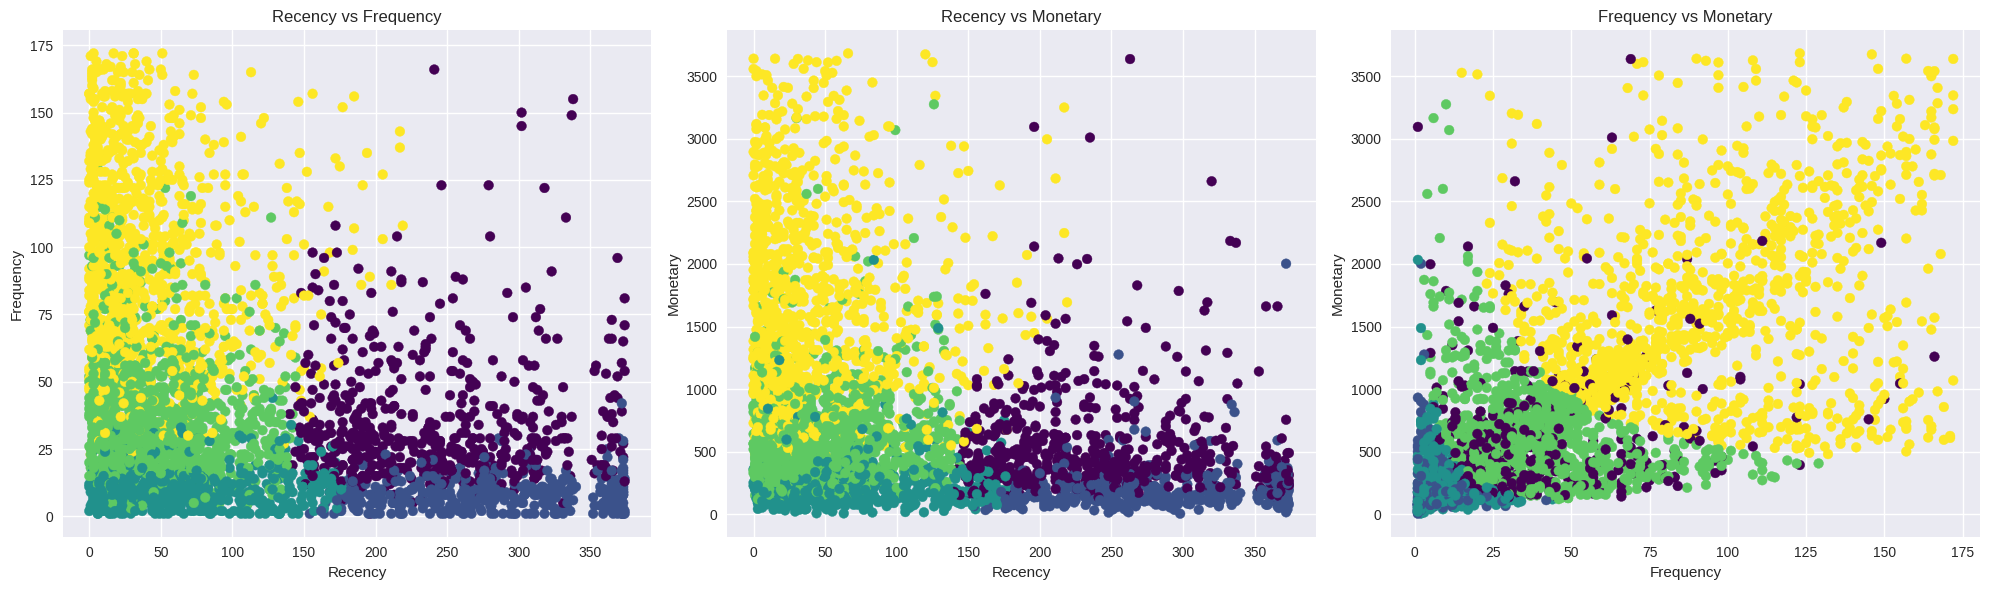

In [24]:
# Gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'],
                     c=rfm['Cluster'], cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Visualización 3D de Clusters RFM')
plt.colorbar(scatter)
plt.show()

# Gráficos 2D
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].scatter(rfm['recency'], rfm['frequency'], c=rfm['Cluster'], cmap='viridis')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')

axes[1].scatter(rfm['recency'], rfm['monetary'], c=rfm['Cluster'], cmap='viridis')
axes[1].set_xlabel('Recency')
axes[1].set_ylabel('Monetary')
axes[1].set_title('Recency vs Monetary')

axes[2].scatter(rfm['frequency'], rfm['monetary'], c=rfm['Cluster'], cmap='viridis')
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary')
axes[2].set_title('Frequency vs Monetary')

plt.tight_layout()
plt.show()

**Clientes de alto valor (Cluster 4)**
- **Estrategia**: Programas de fidelización, ofertas exclusivas, servicio premium.
- **Objetivo**: Mantener su alta frecuencia de compra y aumentar el valor por compra.

**Clientes activos de valor medio (Cluster 3)**
- **Estrategia**: Incentivos para aumentar el valor de compra, cross-selling.
- **Objetivo**: Incrementar el valor monetario de sus compras.

**Clientes recientes de bajo valor (Cluster 2)**
- **Estrategia**: Campañas para aumentar la frecuencia de compra, ofertas atractivas.
- **Objetivo**: Convertirlos en clientes más frecuentes y de mayor valor.

**Clientes de valor medio con baja recencia (Cluster 0)**
- **Estrategia**: Campañas de reactivación, ofertas personalizadas basadas en compras anteriores.
- **Objetivo**: Reducir el tiempo desde la última compra y aumentar la frecuencia.

**Clientes inactivos de bajo valor (Cluster 1)**
- **Estrategia**: Campañas de reactivación agresivas, encuestas para entender la inactividad.
- **Objetivo**: Recuperar estos clientes o decidir si vale la pena invertir en ellos.

### Observaciones generales

Los clusters 3 y 4 (clientes activos y de alto valor) representan la mayor parte de la base de clientes (2115 de 3662, o 57.8%).
Hay una clara diferenciación entre los segmentos en términos de comportamiento de compra.
La recencia parece ser un factor importante en la segmentación, con una clara distinción entre clientes activos e inactivos.

In [25]:
# Asumiendo que tenemos información adicional como 'product_category' y 'purchase_month'
for cluster in rfm['Cluster'].unique():
    cluster_data = rfm[rfm['Cluster'] == cluster]

    print(f"\nAnálisis de Cluster {cluster}")
    print(f"\nEstadísticas RFM Cluster {cluster}")
    display(cluster_data[['recency', 'frequency', 'monetary']].describe())
    print("\n" + "="*50)


Análisis de Cluster 4

Estadísticas RFM Cluster 4


recency    frequency     monetary
count  1052.000000  1052.000000  1052.000000
mean     41.403992    93.500000  1669.668385
std      41.353910    35.588875   753.294216
min       0.000000    15.000000   480.380000
25%      11.000000    65.000000  1070.950000
50%      28.000000    89.000000  1531.095000
75%      58.000000   120.000000  2158.810000
max     219.000000   172.000000  3683.860000



Análisis de Cluster 0

Estadísticas RFM Cluster 0


recency   frequency     monetary
count  549.000000  549.000000   549.000000
mean   240.772313   36.134791   563.934827
std     61.737562   24.019458   415.486268
min    140.000000    1.000000   135.190000
25%    189.000000   20.000000   315.060000
50%    235.000000   29.000000   429.600000
75%    288.000000   44.000000   641.920000
max    374.000000  166.000000  3638.410000



Análisis de Cluster 1

Estadísticas RFM Cluster 1


recency   frequency     monetary
count  404.000000  404.000000   404.000000
mean   278.420792    8.497525   191.928688
std     60.179848    5.840094   164.525542
min    154.000000    1.000000     3.750000
25%    231.000000    4.000000   110.137500
50%    276.000000    8.000000   155.025000
75%    326.000000   11.000000   225.900000
max    374.000000   42.000000  2002.400000



Análisis de Cluster 3

Estadísticas RFM Cluster 3


recency    frequency     monetary
count  1063.000000  1063.000000  1063.000000
mean     48.617121    36.756350   601.511207
std      36.321944    19.573414   346.482339
min       0.000000     3.000000   120.030000
25%      18.000000    23.000000   375.995000
50%      41.000000    33.000000   532.820000
75%      73.000000    46.000000   731.985000
max     144.000000   129.000000  3276.400000



Análisis de Cluster 2

Estadísticas RFM Cluster 2


recency  frequency     monetary
count  594.000000  594.00000   594.000000
mean    67.638047   10.53367   226.333771
std     48.426666    6.85797   169.973889
min      0.000000    1.00000     6.200000
25%     26.000000    6.00000   125.970000
50%     58.000000   10.00000   192.275000
75%    104.250000   14.00000   276.390000
max    179.000000   44.00000  2033.100000

## Análisis de Clusters RFM

### Resumen de Clusters

| Cluster | Nombre | Recencia (días) | Frecuencia | Monetario ($) | Clientes |
|---------|--------|-----------------|------------|---------------|----------|
| 4 | Clientes de alto valor | 41 | 93.5 | 1669 | 1052 |
| 3 | Clientes activos de valor medio | 48 | 36.7 | 601 | 1063 |
| 2 | Clientes recientes de bajo valor | 67 | 10.5 | 226 | 594 |
| 0 | Clientes de valor medio con baja recencia | 240 | 36.1 | 563 | 549 |
| 1 | Clientes inactivos de bajo valor | 278 | 8.5 | 191 | 404 |

### Análisis Detallado

**Cluster 4: Clientes de alto valor**
- **Características**: Muy activos, alta frecuencia, alto valor
- **Estrategia**: Retención y maximización de valor
- **Acciones**:
  1. Implementar programa VIP exclusivo
  2. Ofrecer acceso anticipado a nuevos productos
  3. Proporcionar servicio al cliente dedicado

**Cluster 3: Clientes activos de valor medio**
- **Características**: Activos, frecuencia media, valor medio
- **Estrategia**: Incremento de valor por compra
- **Acciones**:
  1. Crear programa de escalado de compras
  2. Ofrecer paquetes de productos para aumentar el valor por transacción
  3. Desarrollar contenido educativo sobre productos premium

**Cluster 2: Clientes recientes de bajo valor**
- **Características**: Recientes, baja frecuencia, bajo valor
- **Estrategia**: Aumento de frecuencia y valor
- **Acciones**:
  1. Lanzar campaña de "segunda compra" con incentivos
  2. Implementar sistema de recomendaciones personalizadas
  3. Introducir programa de fidelización básico

**Cluster 0: Clientes de valor medio con baja recencia**
- **Características**: Baja recencia, frecuencia media, valor medio
- **Estrategia**: Reactivación personalizada
- **Acciones**:
  1. Desarrollar campaña "te extrañamos" con ofertas especiales
  2. Enviar recordatorios de productos previamente comprados
  3. Realizar encuesta para entender razones de inactividad

**Cluster 1: Clientes inactivos de bajo valor**
- **Características**: Muy baja recencia, baja frecuencia, bajo valor
- **Estrategia**: Recuperación y reactivación
- **Acciones**:
  1. Lanzar campaña de "última oportunidad" con descuentos significativos
  2. Implementar programa de reactivación por etapas
  3. Evaluar ROI de marketing para este grupo

### Observaciones Finales de la Segmentación

- Clara segmentación en términos de valor y actividad del cliente
- Clusters 3 y 4 representan la mayoría de la base de clientes
- Oportunidad de mover clientes entre clusters adyacentes
- Urgencia en estrategias de reactivación para clusters 0 y 1

### Recomendaciones

1. Implementar sistema de puntuación RFM continuo
2. Desarrollar campañas de marketing específicas por cluster
3. Establecer KPIs para medir éxito de estrategias
4. Realizar análisis de cohortes para seguimiento de evolución de clientes
5. Incorporar datos adicionales para segmentación más precisa

## Entrenamiento y pruebas de Modelos Predictivos

<ipython-input-26-ce6b0d7e8b48>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')


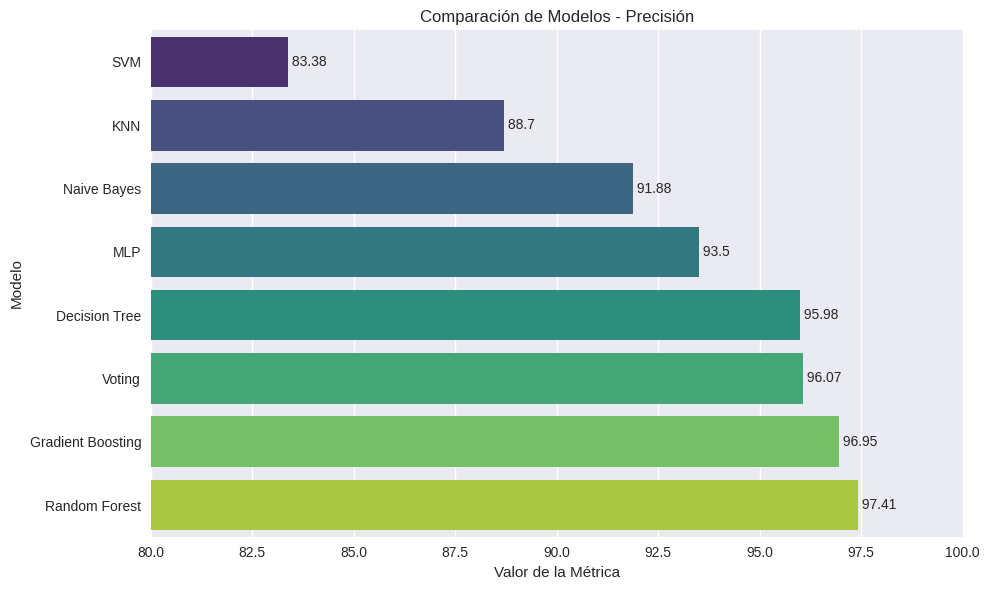

<ipython-input-26-ce6b0d7e8b48>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')


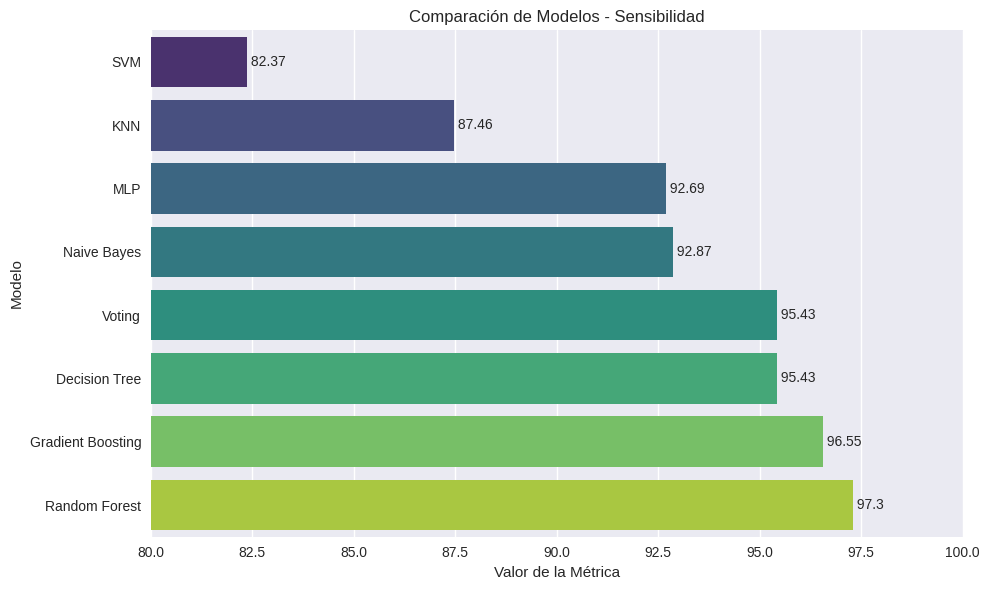

<ipython-input-26-ce6b0d7e8b48>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')


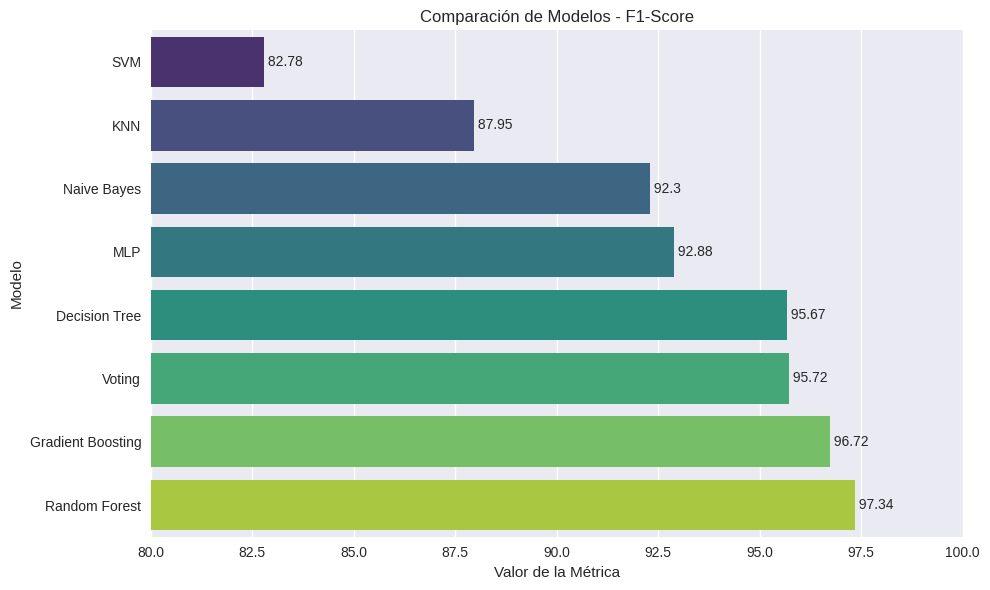

<ipython-input-26-ce6b0d7e8b48>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')


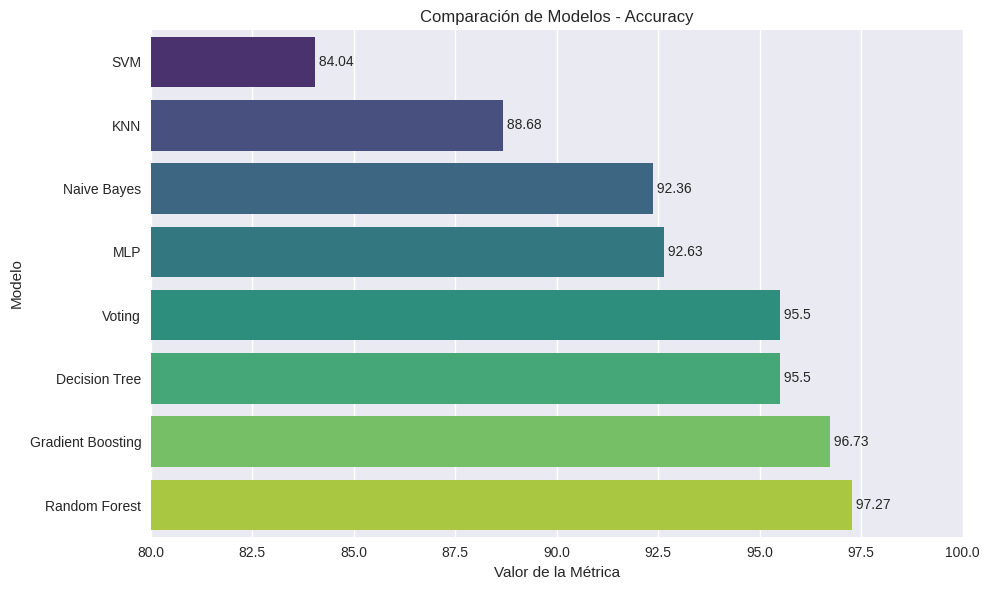

<ipython-input-26-ce6b0d7e8b48>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')


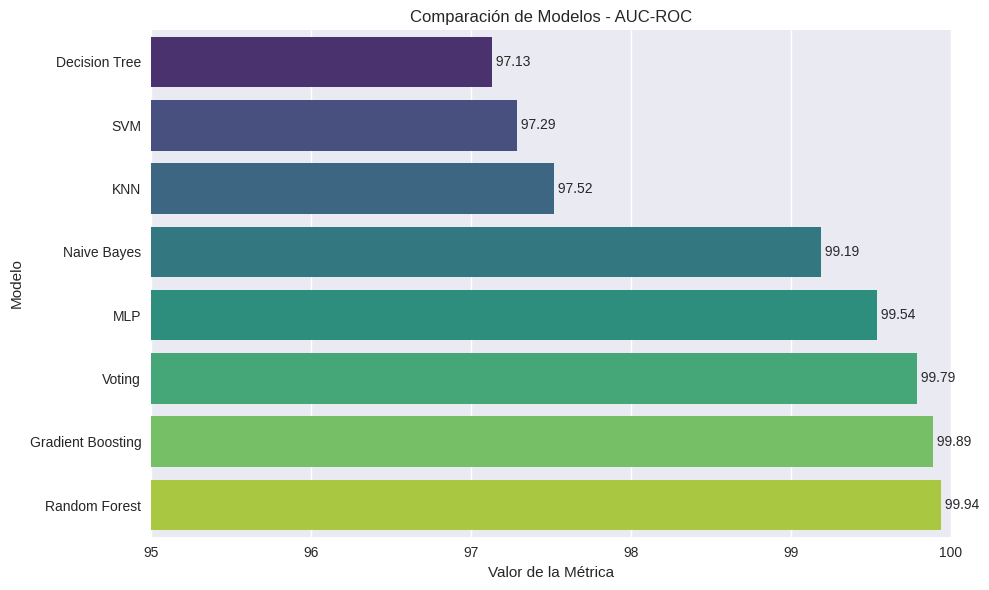

<ipython-input-26-ce6b0d7e8b48>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')


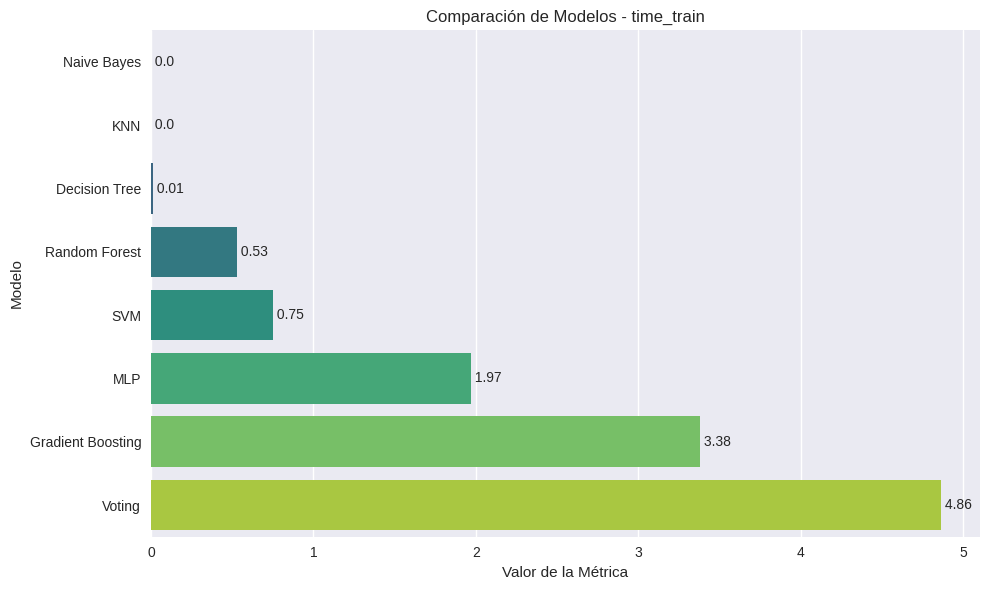

<ipython-input-26-ce6b0d7e8b48>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')


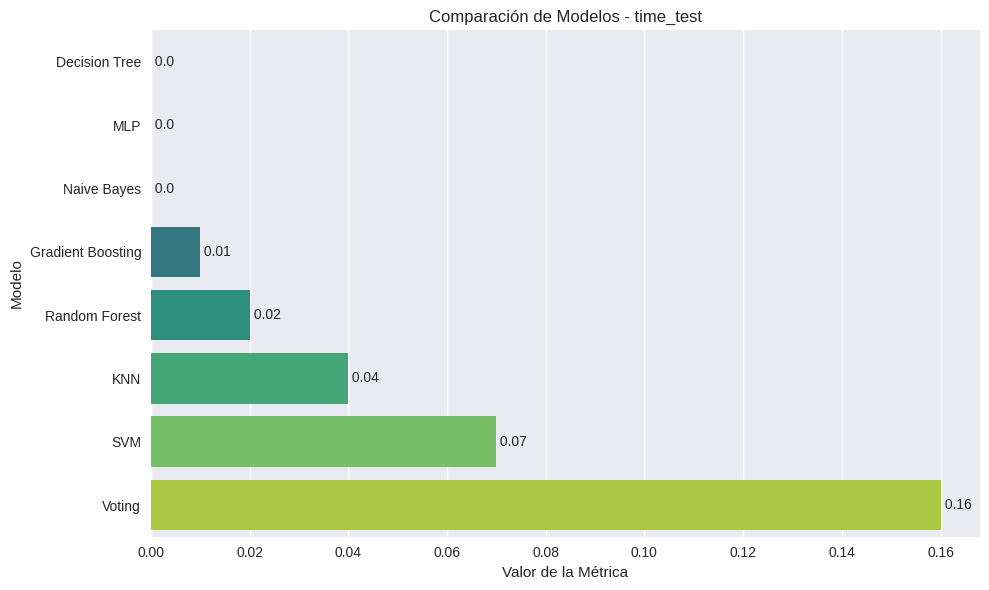

In [26]:
# Preparar los datos
X = rfm.drop('Cluster', axis=1)
y = rfm['Cluster']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Máquina de Soporte Vectorial (SVM)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

# 2. K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# 3. Árbol de Decisión
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# 4. Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# 5. Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# 6. Ensamble de Votación
voting_clf = VotingClassifier(estimators=[
    ('svm', svm),
    ('knn', knn),
    ('tree', tree),
    ('gb', gb),
    ('nb', nb)
], voting='soft')
voting_clf.fit(X_train, y_train)

# 7. Redes Neuronales Artificiales (MLP)
mlp = MLPClassifier(random_state=42, max_iter=500)
mlp.fit(X_train, y_train)

# 8. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

def imprimir_tabla_metricas(modelos, X_train, X_test, y_train, y_test):
    metricas = {}
    n_classes = len(np.unique(y_test))
    is_binary = n_classes == 2

    for nombre, modelo in modelos.items():
        # Medir tiempo de entrenamiento
        start_train = time.time()
        modelo.fit(X_train, y_train)
        end_train = time.time()
        train_time = end_train - start_train

        # Medir tiempo de prueba
        start_test = time.time()
        y_pred = modelo.predict(X_test)
        end_test = time.time()
        test_time = end_test - start_test

        if is_binary:
            y_prob = modelo.predict_proba(X_test)[:, 1]
            auc_roc = roc_auc_score(y_test, y_prob)
        else:
            y_prob = modelo.predict_proba(X_test)
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            auc_roc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr', average='macro')

        metricas[nombre] = {
            'Precisión': precision_score(y_test, y_pred, average='macro'),
            'Sensibilidad': recall_score(y_test, y_pred, average='macro'),
            'F1-Score': f1_score(y_test, y_pred, average='macro'),
            'Accuracy': accuracy_score(y_test, y_pred),
            'AUC-ROC': auc_roc,
            'time_train': train_time,
            'time_test': test_time
        }

    # Crear tabla de métricas
    df_metricas = pd.DataFrame(metricas).T

    # Convertir las métricas de rendimiento a porcentaje
    metricas_porcentaje = ['Precisión', 'Sensibilidad', 'F1-Score', 'Accuracy', 'AUC-ROC']
    df_metricas[metricas_porcentaje] = df_metricas[metricas_porcentaje] * 100

    # Reordenar las columnas
    columnas_orden = ['Precisión', 'Sensibilidad', 'F1-Score', 'Accuracy', 'AUC-ROC', 'time_train', 'time_test']
    df_metricas = df_metricas[columnas_orden]

    # Función para formatear los valores sin ceros después del punto
    def format_value(value):
        if isinstance(value, float):
            return f"{value:.2f}".rstrip('0').rstrip('.')
        return value

    # Aplicar el formato a todas las celdas del DataFrame
    df_metricas = df_metricas.applymap(format_value)

    # Ordenar el DataFrame por la columna 'Precisión' de mayor a menor
    df_metricas_ordenado = df_metricas.sort_values(by='Precisión', ascending=False)

    # Mostrar la tabla ordenada usando display
    display(df_metricas_ordenado.style.set_caption("Tabla de Métricas (rendimiento en porcentaje, tiempos en segundos) - Ordenada por Precisión"))

    return df_metricas_ordenado

def graficar_metrica(df_metricas, metrica):
    # Convertir la columna seleccionada a tipo numérico
    df_metricas[metrica] = pd.to_numeric(df_metricas[metrica])

    # Ordenar el DataFrame por la métrica seleccionada
    df_sorted = df_metricas.sort_values(by=metrica, ascending=True)

    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=df_sorted[metrica], y=df_sorted.index, palette='viridis')

    # Personalizar el gráfico
    plt.title(f'Comparación de Modelos - {metrica}')
    plt.xlabel('Valor de la Métrica')
    plt.ylabel('Modelo')

    # Ajustar el rango del eje x según la métrica
    if metrica in ['Precisión', 'Sensibilidad', 'F1-Score', 'Accuracy']:
        plt.xlim(80, 100)
    elif metrica == 'AUC-ROC':
        plt.xlim(95, 100)

    # Añadir etiquetas de valor en las barras
    for i, v in enumerate(df_sorted[metrica]):
        ax.text(v, i, f' {v}', va='center')

    plt.tight_layout()
    plt.show()

# Uso de las funciones
modelos = {
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Voting': VotingClassifier(estimators=[
        ('svm', SVC(probability=True, random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('tree', DecisionTreeClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('nb', GaussianNB())
    ], voting='soft'),
    'MLP': MLPClassifier(random_state=42, max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Imprimir tabla de métricas
df_metricas = imprimir_tabla_metricas(modelos, X_train, X_test, y_train, y_test)

# Graficar cada métrica
for metrica in ['Precisión', 'Sensibilidad', 'F1-Score', 'Accuracy', 'AUC-ROC']:
    graficar_metrica(df_metricas, metrica)

# Graficar tiempos de entrenamiento y prueba
graficar_metrica(df_metricas, 'time_train')
graficar_metrica(df_metricas, 'time_test')

## Análisis de Rendimiento de Modelos de Machine Learning

### Resumen General
Los datos muestran el rendimiento de 8 modelos de clasificación diferentes, evaluados en 5 métricas distintas. Todos los modelos muestran un rendimiento generalmente bueno, con valores superiores al 80% en todas las métricas.

### Análisis por Modelo

**Random Forest**
- **Mejor rendimiento general**
- Líder en todas las 5 métricas (Precisión, Sensibilidad, F1-Score, Accuracy, AUC-ROC)
- Rendimiento excepcionalmente equilibrado en todas las métricas
- Tiempo de entrenamiento moderado y muy rápido en prueba

**Gradient Boosting**
- Segundo mejor rendimiento general
- Muy cercano al Random Forest en todas las métricas
- Tiempo de entrenamiento largo, pero rápido en prueba

**Voting (Ensamble de Votación)**
- Tercer mejor rendimiento
- Muestra la fuerza de combinar múltiples modelos
- Excelente AUC-ROC (99.79%)
- Tiempo de entrenamiento más largo y rápido en prueba

**Decision Tree (Árbol de Decisión)**
- Sorprendentemente buen rendimiento para un modelo relativamente simple
- Cuarto en la mayoría de las métricas
- Menor AUC-ROC entre los modelos de alto rendimiento (97.13%)
- Extremadamente rápido en entrenamiento y prueba más rápida

**MLP (Red Neuronal)**
- Rendimiento sólido pero no excepcional
- Consistente en todas las métricas
- Tiempo de entrenamiento moderado y muy rápido en prueba

**Naive Bayes**
- Rendimiento sorprendentemente bueno para un modelo tan simple
- Destaca en AUC-ROC (99.19%)
- El más rápido en entrenamiento y prueba

**KNN**
- Rendimiento moderado
- Consistente en todas las métricas
- Muy rápido en entrenamiento y prueba

**SVM**
- Rendimiento más bajo en la mayoría de las métricas
- Aún así, muestra un buen AUC-ROC (97.29%)
- Tiempo de entrenamiento moderado y el más lento en prueba

### Análisis por Métrica

1. **Precisión**: Random Forest lidera (97.41%), seguido de cerca por Gradient Boosting (96.95%).
2. **Sensibilidad**: Random Forest nuevamente en la cima (97.3%), con Gradient Boosting muy cerca (96.55%).
3. **F1-Score**: Random Forest mantiene el liderazgo (97.34%), seguido por Gradient Boosting (96.72%).
4. **Accuracy**: Random Forest continúa dominando (97.27%), con Gradient Boosting en segundo lugar (96.73%).
5. **AUC-ROC**: Todos los modelos muestran un excelente rendimiento, con Random Forest liderando (99.94%), seguido muy de cerca por Gradient Boosting (99.89%) y Voting (99.79%).

### Conclusiones

1. **Random Forest** se destaca como el mejor modelo general, liderando en todas las métricas con un buen equilibrio entre rendimiento y tiempo de ejecución.
2. **Gradient Boosting** es un fuerte competidor, muy cerca del rendimiento de Random Forest, pero con un tiempo de entrenamiento más largo.
3. Los modelos de **ensemble** (Random Forest, Gradient Boosting, Voting) muestran un rendimiento superior, lo que sugiere que la combinación de múltiples modelos es efectiva para este conjunto de datos.
4. Incluso los modelos más simples como **Decision Tree** y **Naive Bayes** muestran un rendimiento sorprendentemente bueno, especialmente considerando su velocidad.
5. El alto rendimiento en **AUC-ROC** para todos los modelos sugiere que son capaces de distinguir bien entre las clases, independientemente del umbral de clasificación elegido.

### Recomendaciones

1. **Utilizar Random Forest** como modelo principal debido a su rendimiento superior, consistente y buen equilibrio entre rendimiento y tiempo de ejecución.
2. Considerar **Gradient Boosting** como una alternativa sólida si el tiempo de entrenamiento no es una limitación crítica.
3. Si la velocidad de inferencia o la interpretabilidad son importantes, el **Decision Tree** podría ser una opción viable dado su buen rendimiento y rapidez extrema.
4. Para aplicaciones que requieran un balance entre rendimiento y simplicidad/velocidad, **Naive Bayes** podría ser una opción sorprendentemente efectiva.
5. Realizar un análisis de las características más importantes utilizadas por Random Forest y Gradient Boosting para obtener insights sobre el problema de clasificación.
6. Considerar el uso de **Voting** si se dispone de recursos computacionales suficientes, ya que ofrece un rendimiento muy alto, aunque con tiempos de ejecución más largos.

# Análisis estadístico de los datos (EDA) considerando nuevos

# Analizando ventas totales

In [27]:
# df.groupby(['region'])['total_price'].sum().sort_values(ascending=False).head(10)
df_2=df.copy()
df_2.head()
df_test = df_2.copy()

<ipython-input-28-f216a56c88a3>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_mes, x='date', y='total_price',palette="viridis")


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '12-2019'),
  Text(1, 0, '1-2020'),
  Text(2, 0, '2-2020'),
  Text(3, 0, '3-2020'),
  Text(4, 0, '4-2020'),
  Text(5, 0, '5-2020'),
  Text(6, 0, '6-2020'),
  Text(7, 0, '7-2020'),
  Text(8, 0, '8-2020'),
  Text(9, 0, '9-2020'),
  Text(10, 0, '10-2020'),
  Text(11, 0, '11-2020'),
  Text(12, 0, '12-2020')])

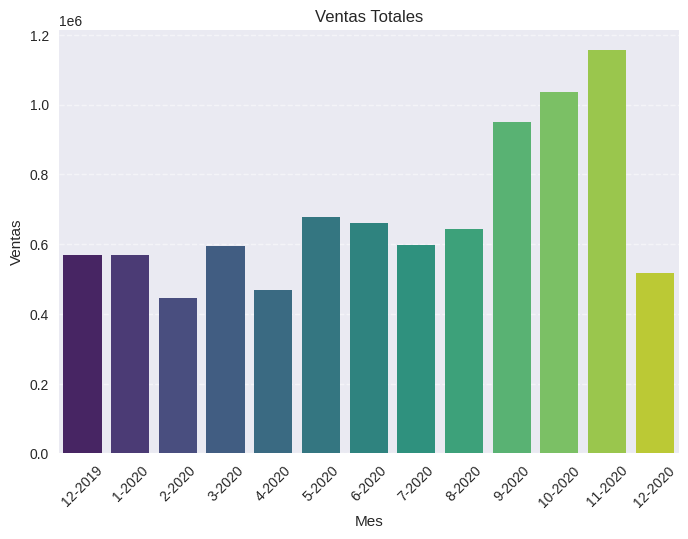

In [28]:
#agregando una columna de fecha, una mes y una de año

df_2['fecha']= df_2['invoice_date'].dt.date
df_2['mes']= df_2['invoice_date'].dt.month
df_2['año']= df_2['invoice_date'].dt.year

#Ahora vamos a hacer la gráfica de barras agrupando por mes y año
df_mes = df_2.groupby(['año', 'mes'])['total_price'].sum().reset_index()

df_mes['date'] = df_mes['mes'].astype(str) + '-' + df_mes['año'].astype(str)

sns.barplot(data=df_mes, x='date', y='total_price',palette="viridis")
plt.title('Ventas Totales')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().set_axisbelow(True)

plt.xticks(rotation=45)

El grafico nos muestra que las ventas de la empresa van mejorando mes con mes, si observamos la venta de diciembre de 2019 podemos ver que fue de menos de €600,000 euros, si la comparamos con diciembre de 2020 el valor es muy similar sin embargo lamentablemente para diciembre de 2020 sólo tenemos datos del 1ro al 9 de diciembre, por lo que sin duda el cierre de diciembre del 2020 será mucho mejor que el del año pasado.

In [29]:
rfm2=rfm.copy()
rfm2.reset_index(inplace=True)
customer_id = rfm2['customer_id']

# filtrando el dataframe inicial considerando solamente valores no outliers
df_w_cid= df.copy()
df_w_cid = df_w_cid[df_w_cid['customer_id'].isin(customer_id)]

In [30]:
# df_w_cid.groupby(['region'])['total_price'].sum().sort_values(ascending=False).head(10)


In [31]:
# hacemos merge para obtener la combinación del dataframe inicial y el dataframe con las métricas
mdf = pd.merge(df_w_cid,rfm2, on='customer_id', how='left')
mdf.drop(columns=['log_frequency','recency','frequency','monetary','log_monetary'],inplace=True)

#obteniendo las ventas totales por región
total_sales_region = pd.DataFrame( mdf.groupby(['region','Cluster'])['total_price'].sum()).reset_index()

#obteniendo las ventas totales por región (incluyendo UK)
top_10_series_sales_w_uk = total_sales_region.groupby('region').sum().sort_values(by='total_price',ascending=False)['total_price'].head(10)

#eliminando UK del dataframe
total_sales_region = total_sales_region[total_sales_region['region']!='United Kingdom']

#Obteniendo las 10 regiones con mayor cantidad de ventas
top_10_series_sales = total_sales_region.groupby('region').sum().sort_values(by='total_price',ascending=False)['total_price'].head(10)

mdf_2= mdf.copy()

# Ventas por región

In [32]:
#Gráfico de ventas totales por región de las regiones top 10 por ventas (incluyendo UK)
fig = px.bar(top_10_series_sales_w_uk ,x=top_10_series_sales_w_uk.index , y = top_10_series_sales_w_uk.values,
             color=top_10_series_sales_w_uk.values , color_continuous_scale='Viridis')
fig.update_layout(
    xaxis_title='Region',
    yaxis_title='Total sales',
    title={
        'text': 'Total sales by region',
        'x':0.5,
        'xanchor':'center'
    },
    showlegend=False



)
fig.show()

fig.write_image('/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/sales_by_region_top_10_w_uk.png')

En esta gráfica podemos ver que el Reino Unido tiene la mayor cantidad de ventas, (este fue un determinante para dividir el análisis en 2 partes, la primera considerando las ventas de este país y la segunda analizando las ventas sin él. Además, podemos notar que el resto de los países con mayor venta son europeos. Lo que deja el resto de los continentes con una participación del 2%

# Ventas totales Sin Reino Unido

In [33]:
#Gráfico de ventas totales por región de las regiones top 10 por ventas sin incluir UK
fig = px.bar(top_10_series_sales ,x=top_10_series_sales.index , y = top_10_series_sales.values,
             color=top_10_series_sales.values , color_continuous_scale='Viridis')
fig.update_layout(
    xaxis_title='Region',
    yaxis_title='Total sales',
    title={
        'text': 'Total sales by region',
        'x':0.5,
        'xanchor':'center'
    },
    showlegend=False



)
fig.show()

fig.write_image('/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/sales_by_region_top_10.png')

En este gráfico se puede apreciar mejor las ventas del top ten de los países (sin considerar al Reino Unido), como habíamos mencionado la mayor recaudación de la empresa proviene de países europeos, principalmente de Alemania, Francia quienes realizaron compras (en el periodo estudiado) por más de €70,000 y €60,000 euros, respectivamente

# Valor del ticket total por pedido en Reino Unido:

   customer_id  total_price
0        12820       942.34
1        12821        92.72
2        12822       948.88
3        12823      1759.50
4        12824       397.12


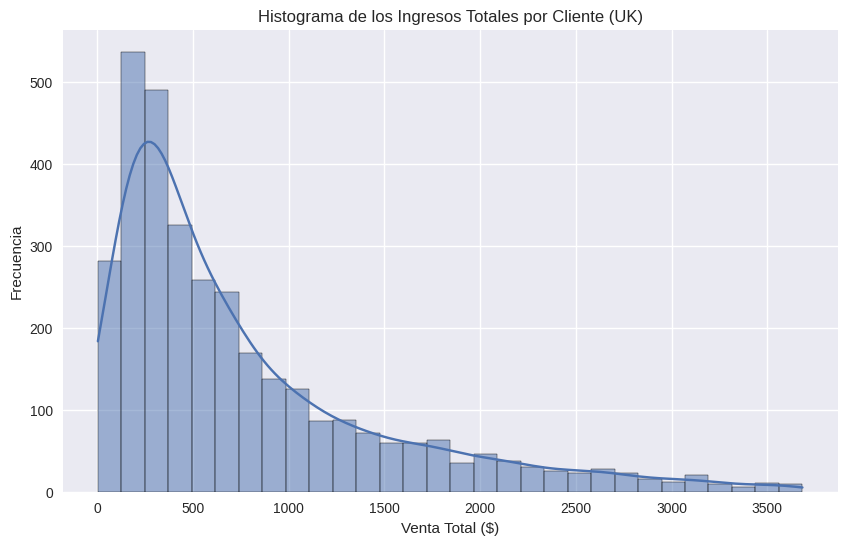

In [34]:
#Creamos un dataframe para ilustrar el histograma de ingresos totales por cliente en UK
mdf_uk = mdf_2[mdf_2['region']=='United Kingdom']

#histograma de las ventas totales por cliente
# Agrupar por cliente para calcular la venta total de cada cliente
ventas_por_cliente = mdf_uk.groupby('customer_id')['total_price'].sum().reset_index()

print(ventas_por_cliente.head())

#histograma
plt.figure(figsize=(10, 6))
sns.histplot(ventas_por_cliente['total_price'], bins=30, kde=True)
plt.title('Histograma de los Ingresos Totales por Cliente (UK)')
plt.xlabel('Venta Total ($)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Con este gráfico queremos ilustrar cuanto están gastando nuestros clientes al adquirir cada pedido, como podemos ver, la mayoría de los pedidos cuestán en promedio €300 euros. Aunque tenemos clientes que hacen pedidos más grandes y llegan a gastar cantidades superiores a los €3,500 euros. Cabe mencionar que esta cantidad incluye el costo del envío.

In [35]:
#definiendo los top 10 regiones
top_countries= ['Germany','France','Belgium','Switzerland','Portugal','Italy','Spain','Channel Islands','Austria','Finland']

# Dataset conservando únicamente las regiones top 10 por ventas
mdf_top_sales = mdf[mdf['region'].isin(top_countries)]
mdf_top_sales.head(2)

invoice_no stock_code             description  quantity  \
2009     536840      22961  JAM MAKING SET PRINTED        12   
2010     536840      22962   JAM JAR WITH PINK LID        12   

            invoice_date  unit_price  customer_id   region continente  \
2009 2019-12-02 18:27:00        1.45        12738  Germany     Europa   
2010 2019-12-02 18:27:00        0.85        12738  Germany     Europa   

      total_price  Cluster  
2009         17.4        1  
2010         10.2        1

In [36]:
# Generando tabla pivote para obtener los productos top de ventas por región
pivot_data = mdf_top_sales.pivot_table(index='description',columns='region', values='total_price', aggfunc='sum')
pv= pivot_data[['Austria']].dropna()

pivot_data.head(5)

region                          Austria  Belgium  Channel Islands  Finland  \
description                                                                  
 50'S CHRISTMAS GIFT BAG LARGE      NaN      NaN              NaN      NaN   
 DOLLY GIRL BEAKER                 15.0     45.0              NaN      NaN   
 I LOVE LONDON MINI BACKPACK        NaN      NaN              NaN      NaN   
 NINE DRAWER OFFICE TIDY            NaN      NaN              NaN     29.9   
 RED SPOT GIFT BAG LARGE            NaN      NaN              NaN      NaN   

region                          France  Germany  Italy  Portugal  Spain  \
description                                                               
 50'S CHRISTMAS GIFT BAG LARGE     NaN     15.0    NaN     15.00    NaN   
 DOLLY GIRL BEAKER                15.0     15.0    NaN       NaN    NaN   
 I LOVE LONDON MINI BACKPACK      33.2     16.6    NaN       NaN    NaN   
 NINE DRAWER OFFICE TIDY           NaN      NaN    NaN     14.95    NaN   
 RED SPOT GIFT BAG LARGE           NaN     15.0    NaN       NaN    NaN   

region                          Switzerland  
description                                  
 50'S CHRISTMAS GIFT BAG LARGE          NaN  
 DOLLY GIRL BEAKER                      NaN  
 I LOVE LONDON MINI BACKPACK            NaN  
 NINE DRAWER OFFICE TIDY                NaN  
 RED SPOT GIFT BAG LARGE                NaN

In [37]:
#Obtenemos un diccionario que contiene un dataframe con los top 5 artículos más vendidos (total_sales) por region en las regiones top_10
dfs={}

for region in pivot_data.columns:
  dfs[region] = pivot_data[[region]].dropna()
  dfs[region] = dfs[region].reset_index()
  dfs[region].rename(columns={region:'total_sales'},inplace=True)
  dfs[region].sort_values(by='total_sales', ascending=False,inplace=True)
  dfs[region].rename_axis('',axis=1,inplace=True)
  dfs[region] = dfs[region].head(5)
  dfs[region].reset_index(drop=True, inplace=True)
  dfs[region]['total_sales']=dfs[region]['total_sales'].astype(int)

#Si queremos saber que llaves (regiones) tenemos en el diccionario:
print(dfs.keys())
# accedenmos a cada dataframe a través de su atributo keys()
dfs['Germany'].head()

dict_keys(['Austria', 'Belgium', 'Channel Islands', 'Finland', 'France', 'Germany', 'Italy', 'Portugal', 'Spain', 'Switzerland'])


description  total_sales
0                              POSTAGE         7164
1  ROUND SNACK BOXES SET OF4 WOODLAND          1362
2             REGENCY CAKESTAND 3 TIER         1336
3                               Manual         1211
4               RED RETROSPOT UMBRELLA          844

# Graficando top 5 productos más vendidos por región (top 10 regiones con más ventas)

In [38]:
#generando gráfico de top 5 sellers por región (sin uk)
for region, df in dfs.items():
  fig = px.bar(df , y='description', x ='total_sales', color='total_sales',color_continuous_scale='Viridis')
  fig.update_layout(
    xaxis_title='Total sales in local currency',
    yaxis_title='Product name',
    title={
        'text': f'Top 5 sellers in {region}',
        'x':0.5,
        'xanchor':'center'
    },
    showlegend=False

  )
  file_name = f'/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/top_5_sellers_top10_ by_region_{region}.png'
  fig.write_image(file_name)
  fig.show()

El producto más vendido dentro de los demás países europeos como Alemania, francia, Bélgica, Portugal, Italia, España, entre otros, corresponde a “Postage”.

In [39]:
# Cuales son los top 5 productos de la región con más recaudación monetaria ? UK
mdf_top_sales_uk = mdf[mdf['region']=='United Kingdom']
mdf_top_sales_uk = mdf_top_sales_uk.groupby(['description'])['total_price'].sum().sort_values(ascending=False).head(5)
mdf_top_sales_uk = pd.DataFrame(mdf_top_sales_uk).reset_index()
mdf_top_sales_uk['total_price'] = mdf_top_sales_uk['total_price'].astype(int)

mdf_top_sales_uk.head(2)

description  total_price
0            REGENCY CAKESTAND 3 TIER        30399
1  WHITE HANGING HEART T-LIGHT HOLDER        27912

# Graficando top 5 productos más vendidos en UK

In [40]:
#Graficando los top 5 sellers en UK
fig = px.bar(mdf_top_sales_uk ,x='total_price',y='description', color='total_price',color_continuous_scale='Viridis' )
fig.update_layout(
    xaxis_title='Total sales',
    yaxis_title='Product Description',
    title={
        'text': 'Top 5 sellers in UK region',
        'x':0.5,
        'xanchor':'center'
    },
    showlegend=False

)
fig.show()
fig.write_image('/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/top_5_sellers_byincome_uk.png')

El producto más vendido “Regency Cakestand 3 tier”, representa el 1.64% de la venta total del Reino Unido.

In [41]:
#Generando pivot table para obtener la cantidad de recaudación por cluster y región
pivot_data_cluster = mdf_top_sales.pivot_table(index='region',columns='Cluster', values='total_price', aggfunc='sum')
pivot_data_cluster

Cluster                0        1        2         3         4
region                                                        
Austria          2469.09   166.04      NaN   2618.08   4507.49
Belgium          1035.61   499.80      NaN   3737.40  22444.43
Channel Islands  3738.06      NaN      NaN   1432.00   7133.46
Finland           511.36      NaN   358.90   1718.13   7119.35
France           4078.09  1415.44  1218.59  13053.78  43100.64
Germany          8829.48   637.30  1955.90  16391.63  45472.66
Italy            2282.03      NaN   374.25   1305.67  13521.29
Portugal         1950.18   565.98      NaN   3084.56  12950.84
Spain            1079.40   471.00   503.34   4898.79  10193.35
Switzerland      4280.40      NaN      NaN   3876.06  13569.38

In [42]:
#Obtenemos un diccionario que contiene un dataframe con los clusters y sus ventas totales por region en las regiones top_10
dfs_cluster={}

for region in pivot_data_cluster.columns:
  dfs_cluster[region] = pivot_data_cluster[[region]].dropna()
  dfs_cluster[region] = dfs_cluster[region].reset_index()
  dfs_cluster[region].rename(columns={region:'total_sales'},inplace=True)
  dfs_cluster[region].sort_values(by='total_sales', ascending=False,inplace=True)
  dfs_cluster[region].rename_axis('',axis=1,inplace=True)
  dfs_cluster[region] = dfs_cluster[region].head(5)
  dfs_cluster[region].reset_index(drop=True, inplace=True)
  dfs_cluster[region]['total_sales']=dfs_cluster[region]['total_sales'].astype(int)

#Si queremos saber que llaves (regiones) tenemos en el diccionario:
print(dfs_cluster.keys())
#si queremos acceder al dataframe de una región lo hacemos a través de su atributo keys()
dfs_cluster[0].head()

dict_keys([0, 1, 2, 3, 4])


region  total_sales
0          Germany         8829
1      Switzerland         4280
2           France         4078
3  Channel Islands         3738
4          Austria         2469

# Graficando top 5 regiones por ventas por cluster

In [43]:
# Graficando top 5 regiones por ventas totales en cada cluster (0-4)
for cluster, df in dfs_cluster.items():
  fig = px.bar(df , x='region', y ='total_sales', color='total_sales' ,color_continuous_scale='Viridis')
  fig.update_layout(
    xaxis_title='Region',
    yaxis_title='Total sales in local currency',
    title={
        'text': f'Top 5 regions by total sales in cluster {cluster}',
        'x':0.5,
        'xanchor':'center'
    },
    showlegend=False,
  )
  file_name = f'/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/total_sales_bytopp_5region_cluster_{cluster}.png'
  fig.write_image(file_name)

  fig.show()

### Resumen de Clusters

| Cluster | Nombre | Recencia (días) | Frecuencia | Monetario ($) | Clientes |
|---------|--------|-----------------|------------|---------------|----------|
| 4 | Clientes de alto valor | 41 | 93.5 | 1669 | 1052 |
| 3 | Clientes activos de valor medio | 48 | 36.7 | 601 | 1063 |
| 2 | Clientes recientes de bajo valor | 67 | 10.5 | 226 | 594 |
| 0 | Clientes de valor medio con baja recencia | 240 | 36.1 | 563 | 549 |
| 1 | Clientes inactivos de bajo valor | 278 | 8.5 | 191 | 404 |

### Análisis Detallado

**Cluster 4: Clientes de alto valor**
- **Características**: Muy activos, alta frecuencia, alto valor
- **Estrategia**: Retención y maximización de valor
- **Acciones**:
  1. Implementar programa VIP exclusivo
  2. Ofrecer acceso anticipado a nuevos productos
  3. Proporcionar servicio al cliente dedicado

**Cluster 3: Clientes activos de valor medio**
- **Características**: Activos, frecuencia media, valor medio
- **Estrategia**: Incremento de valor por compra
- **Acciones**:
  1. Crear programa de escalado de compras
  2. Ofrecer paquetes de productos para aumentar el valor por transacción
  3. Desarrollar contenido educativo sobre productos premium

**Cluster 2: Clientes recientes de bajo valor**
- **Características**: Recientes, baja frecuencia, bajo valor
- **Estrategia**: Aumento de frecuencia y valor
- **Acciones**:
  1. Lanzar campaña de "segunda compra" con incentivos
  2. Implementar sistema de recomendaciones personalizadas
  3. Introducir programa de fidelización básico

**Cluster 0: Clientes de valor medio con baja recencia**
- **Características**: Baja recencia, frecuencia media, valor medio
- **Estrategia**: Reactivación personalizada
- **Acciones**:
  1. Desarrollar campaña "te extrañamos" con ofertas especiales
  2. Enviar recordatorios de productos previamente comprados
  3. Realizar encuesta para entender razones de inactividad

**Cluster 1: Clientes inactivos de bajo valor**
- **Características**: Muy baja recencia, baja frecuencia, bajo valor
- **Estrategia**: Recuperación y reactivación
- **Acciones**:
  1. Lanzar campaña de "última oportunidad" con descuentos significativos
  2. Implementar programa de reactivación por etapas
  3. Evaluar ROI de marketing para este grupo

### Observaciones Finales de la Segmentación

- Clara segmentación en términos de valor y actividad del cliente
- Clusters 3 y 4 representan la mayoría de la base de clientes
- Oportunidad de mover clientes entre clusters adyacentes
- Urgencia en estrategias de reactivación para clusters 0 y 1






# Generando mapas de calor para visualizaciones regionales

In [44]:
#importando datos shapefile y creando objetos geopandas
countries_raw = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/world_map/ne_110m_admin_0_countries.shp')
countries_raw = countries_raw[['SOVEREIGNT','ISO_A3','geometry']]
countries_raw.head(2)

SOVEREIGNT ISO_A3  \
0                         Fiji    FJI   
1  United Republic of Tanzania    TZA   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...

In [45]:
#Lista de paises donde tenemos ventas
c_list = ['GBR','NLD','DEU','FRA','CHE','PRT','ITA','BEL','LTU','JPN','AUS','CYP','FIN',
 'AUT','ESP','SWE','GRC','LBN','NOR','POL','ARE','ISR','DNK','SAU','CZE','CAN','BRA','USA',
 'BHR','','MLT','ZAF','-99']

#Dataframe de los países donde tenemos ventas
countries = countries_raw[countries_raw['ISO_A3'].isin(c_list)][['SOVEREIGNT','ISO_A3','geometry']]

len(c_list)

33

In [46]:
#normalizando columnas y nombres de países
countries.rename(columns={'SOVEREIGNT':'region'},inplace=True)
to_replace={'South Africa':'RSA',
            'United States of America':'USA',
            'Czechia':'Czech Republic'}
countries['region'] = countries['region'].replace(to_replace)
countries.head(2)

region ISO_A3                                           geometry
3  Canada    CAN  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4     USA    USA  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [47]:
#creamos un dataframe copy del mdf en caso de que en futuros análisis se requiera esa información, sin tener la información geoespacial
map_df_raw = mdf.copy()
# creamos un merge entre la información geoespacial y los registros de ventas
map_df_raw = pd.merge(map_df_raw,countries ,on='region', how='left')
map_df_raw.head(1)

invoice_no stock_code                    description  quantity  \
0     536367      84879  ASSORTED COLOUR BIRD ORNAMENT        32   

         invoice_date  unit_price  customer_id          region continente  \
0 2019-12-01 08:34:00        1.69        13047  United Kingdom     Europa   

   total_price  Cluster ISO_A3  \
0        54.08        4    GBR   

                                            geometry  
0  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...

In [48]:
#Eliminamos las regiones de las cuales no se tienen datos geoespaciales
print(map_df_raw[map_df_raw['ISO_A3'].isnull()]['region'].unique())
map_df_raw =map_df_raw[~map_df_raw['region'].isin( ['Channel Islands', 'Unspecified', 'European Community', 'Bahrain',
       'Malta'] )]

['Channel Islands' 'Unspecified' 'European Community' 'Bahrain' 'Malta']


In [49]:
# Reemplazamos RSA (South Africa )que pertenece a  Africa, no a Europa
map_df_raw.loc[map_df_raw['region']== 'RSA','continente'] ='Africa'

In [50]:
#convertimos el dataframe a Geodataframe
map_df_raw = gpd.GeoDataFrame(map_df_raw,crs="EPSG:4326")

# Obtenemos los puntos representativos de los paises para poder pinnear sus nombres
map_df_raw['coords'] = map_df_raw['geometry'].apply(lambda x : x.representative_point().coords[:])
map_df_raw['coords'] =[coords[0] for  coords in map_df_raw['coords']]


In [51]:
map_df_raw.head(2)

invoice_no stock_code                    description  quantity  \
0     536367      84879  ASSORTED COLOUR BIRD ORNAMENT        32   
1     536367      22745     POPPY'S PLAYHOUSE BEDROOM          6   

         invoice_date  unit_price  customer_id          region continente  \
0 2019-12-01 08:34:00        1.69        13047  United Kingdom     Europa   
1 2019-12-01 08:34:00        2.10        13047  United Kingdom     Europa   

   total_price  Cluster ISO_A3  \
0        54.08        4    GBR   
1        12.60        4    GBR   

                                            geometry  \
0  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...   
1  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...   

                                    coords  
0  (-1.753312127795028, 54.22468791362445)  
1  (-1.753312127795028, 54.22468791362445)

In [52]:
#Creamos un dataframe conformado solamente por los países y poligonos, basado en map_df_raw
map_geometry = map_df_raw[['region', 'geometry','continente']].drop_duplicates().reset_index(drop=True)
map_geometry = gpd.GeoDataFrame(map_geometry,crs="EPSG:4326")

# Obtenemos los puntos representativos de los paises para poder pinnear sus nombres
map_geometry['coords'] = map_geometry['geometry'].apply(lambda x : x.representative_point().coords[:])
map_geometry['coords'] =[coords[0] for  coords in map_geometry['coords']]

map_geometry.head(2)

region                                           geometry  \
0  United Kingdom  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...   
1     Netherlands  POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...   

  continente                                   coords  
0     Europa  (-1.753312127795028, 54.22468791362445)  
1     Europa   (5.398113217342898, 52.04023468689047)

In [53]:
#Creamos un dataframe con datos geoespaciales para filtrar la cantidad de pedidos por región
invoice_q_map= pd.DataFrame(map_df_raw.groupby('region').count().sort_values(by='invoice_no',ascending=False)[['quantity']])
invoice_q_map.reset_index(inplace=True)

invoice_q_map_df = pd.merge(invoice_q_map,map_geometry, on='region')
invoice_q_map_df = gpd.GeoDataFrame(invoice_q_map_df,crs="EPSG:4326" )

#Creamos una columna 'log_quantity' para poder visualizar un mapa de calor en escalas medibles
invoice_q_map_df['log_quantity'] = np.log1p(invoice_q_map_df['quantity'])
invoice_q_map_df.head(2)

invoice_q_map_df.head(1)

region  quantity  \
0  United Kingdom    151407   

                                            geometry continente  \
0  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...     Europa   

                                    coords  log_quantity  
0  (-1.753312127795028, 54.22468791362445)     11.927733

# Mapa de presencia de ventas mundiales

In [54]:
#Generamos mapa de calor de Cantidad pedidos por región
fig = px.choropleth_mapbox(invoice_q_map_df,
                           geojson=invoice_q_map_df.geometry,  # Especificar la geometría
                           locations=invoice_q_map_df.index,   # Ubicaciones (puede ser cualquier columna de identificación)
                           color='log_quantity',    # Datos para colorear
                           mapbox_style="carto-positron",
                           center={"lat": 0, "lon": 0},
                           zoom=2,
                           labels = {'log_quantity':'invoices count'},
                           hover_name = 'region',
                           color_continuous_scale='Viridis'
                           )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, showlegend=False,    coloraxis_showscale=False )

fig.write_html("/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/front_map.html")
fig.show()

En el análisis nos dimos cuenta de que la mayor cantidad de ventas se genera en el Reino Unido, ya que esta región participa con más del 90% de las ventas. Además, podemos ver que la empresa tiene clientes no sólo en Europa, sino que también llega a América, África, Oceanía y Asia.

**Busquemos la cantidad de ingresos por región y cluster**

In [55]:
#Generamos una tabla pivote con la cantidad de ingresos por región y cluster
pivot_data_map_cluster = map_df_raw.pivot_table(index='region',columns='Cluster', values='total_price', aggfunc='sum')
pivot_data_map_cluster_test = pivot_data_map_cluster.reset_index()
pivot_data_map_cluster_test.rename_axis('',axis=1,inplace=True)

#Generamos una tabla pivote con la cantidad de ingresos por región y cluster sin UK
pivot_data_map_cluster_test_without_uk =  pivot_data_map_cluster_test[pivot_data_map_cluster_test['region']!='United Kingdom']
pivot_data_map_cluster_test.head(2)


region        0       1       2        3        4
0  Australia  1760.96  401.90  373.65  1192.34  4363.26
1    Austria  2469.09  166.04     NaN  2618.08  4507.49

In [56]:
#Creamos un diccionario de dataframes donde guardamos un dataframe para cada cluster
dfs_map_clusters = {}
for cluster in range(5):
  dfs_map_clusters[f'map_cluster{cluster}'] = pivot_data_map_cluster_test[['region', cluster]]
  dfs_map_clusters[f'map_cluster{cluster}'] = dfs_map_clusters[f'map_cluster{cluster}'].dropna()
  dfs_map_clusters[f'map_cluster{cluster}'].rename(columns={cluster :  f'ingresos cluster {cluster}'},inplace=True)
  dfs_map_clusters[f'map_cluster{cluster}']['log_sales'] = np.log1p(dfs_map_clusters[f'map_cluster{cluster}'][f'ingresos cluster {cluster}'])

print(dfs_map_clusters.keys())
dfs_map_clusters['map_cluster3'].head(3)


dict_keys(['map_cluster0', 'map_cluster1', 'map_cluster2', 'map_cluster3', 'map_cluster4'])


region  ingresos cluster 3  log_sales
0  Australia             1192.34   7.084511
1    Austria             2618.08   7.870578
2    Belgium             3737.40   8.226413

In [57]:
#Creamos un diccionario de dataframes donde guardamos un dataframe para cada cluster sin UK
dfs_map_clusters_w_uk = {}
for cluster in range(5):
  dfs_map_clusters_w_uk[f'map_cluster{cluster}'] = pivot_data_map_cluster_test_without_uk[['region', cluster]]
  dfs_map_clusters_w_uk[f'map_cluster{cluster}'] = dfs_map_clusters_w_uk[f'map_cluster{cluster}'].dropna()
  dfs_map_clusters_w_uk[f'map_cluster{cluster}'].rename(columns={cluster :  f'ingresos cluster {cluster}'},inplace=True)
  dfs_map_clusters_w_uk[f'map_cluster{cluster}']['log_sales'] = np.log1p(dfs_map_clusters_w_uk[f'map_cluster{cluster}'][f'ingresos cluster {cluster}'])

print(dfs_map_clusters.keys())
dfs_map_clusters_w_uk['map_cluster3'].head()


dict_keys(['map_cluster0', 'map_cluster1', 'map_cluster2', 'map_cluster3', 'map_cluster4'])


region  ingresos cluster 3  log_sales
0       Australia             1192.34   7.084511
1         Austria             2618.08   7.870578
2         Belgium             3737.40   8.226413
5          Cyprus             1040.05   6.947985
6  Czech Republic              826.74   6.718699

In [58]:
#Obtenemos un dataframe para cada cluster incluyendo sus geometrias
#Cluster 0
df_map_cl0 = pd.merge(dfs_map_clusters['map_cluster0'] ,map_geometry, on='region' )
df_map_cl0 = gpd.GeoDataFrame(df_map_cl0,crs="EPSG:4326" )

#Cluster 1
df_map_cl1 = pd.merge(dfs_map_clusters['map_cluster1'] ,map_geometry, on='region' )
df_map_cl1 = gpd.GeoDataFrame(df_map_cl1,crs="EPSG:4326" )

#Cluster 2
df_map_cl2 = pd.merge(dfs_map_clusters['map_cluster2'] ,map_geometry, on='region' )
df_map_cl2 = gpd.GeoDataFrame(df_map_cl2,crs="EPSG:4326" )

#Cluster 3
df_map_cl3 = pd.merge(dfs_map_clusters['map_cluster3'] ,map_geometry, on='region' )
df_map_cl3 = gpd.GeoDataFrame(df_map_cl3,crs="EPSG:4326" )

#Cluster 4
df_map_cl4 = pd.merge(dfs_map_clusters['map_cluster4'] ,map_geometry, on='region' )
df_map_cl4 = gpd.GeoDataFrame(df_map_cl4,crs="EPSG:4326" )
df_map_cl4.head(2)

region  ingresos cluster 4  log_sales  \
0  Australia             4363.26   8.381204   
1    Austria             4507.49   8.413718   

                                            geometry continente  \
0  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...    Oceanía   
1  POLYGON ((16.97967 48.12350, 16.90375 47.71487...     Europa   

                                      coords  
0  (133.05858125705473, -24.841454969992654)  
1    (14.953149823900707, 47.91918132180231)

In [59]:
#Obtenemos un dataframe para cada cluster incluyendo sus geometrias (sin UK)
#Cluster 0
df_map_cl0_wo = pd.merge(dfs_map_clusters_w_uk['map_cluster0'] ,map_geometry, on='region' )
df_map_cl0_wo = gpd.GeoDataFrame(df_map_cl0_wo,crs="EPSG:4326" )

#Cluster 1
df_map_cl1_wo = pd.merge(dfs_map_clusters_w_uk['map_cluster1'] ,map_geometry, on='region' )
df_map_cl1_wo = gpd.GeoDataFrame(df_map_cl1_wo,crs="EPSG:4326" )

#Cluster 2
df_map_cl2_wo = pd.merge(dfs_map_clusters_w_uk['map_cluster2'] ,map_geometry, on='region' )
df_map_cl2_wo = gpd.GeoDataFrame(df_map_cl2_wo,crs="EPSG:4326" )

#Cluster 3
df_map_cl3_wo = pd.merge(dfs_map_clusters_w_uk['map_cluster3'] ,map_geometry, on='region' )
df_map_cl3_wo = gpd.GeoDataFrame(df_map_cl3_wo,crs="EPSG:4326" )

#Cluster 4
df_map_cl4_wo = pd.merge(dfs_map_clusters_w_uk['map_cluster4'] ,map_geometry, on='region' )
df_map_cl4_wo = gpd.GeoDataFrame(df_map_cl4_wo,crs="EPSG:4326" )
df_map_cl4_wo.head(2)

region  ingresos cluster 4  log_sales  \
0  Australia             4363.26   8.381204   
1    Austria             4507.49   8.413718   

                                            geometry continente  \
0  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...    Oceanía   
1  POLYGON ((16.97967 48.12350, 16.90375 47.71487...     Europa   

                                      coords  
0  (133.05858125705473, -24.841454969992654)  
1    (14.953149823900707, 47.91918132180231)

# Mapa de calor de ventas por región y cluster

In [60]:

#generamos figura y mapa para visualización de ventas por cluster y región sin UK
fig = go.Figure()
for df , cluster in zip ([df_map_cl0_wo,df_map_cl1_wo,df_map_cl2_wo,df_map_cl3_wo,df_map_cl4_wo],['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4'] ):
  fig.add_trace(
      go.Choroplethmapbox(
          geojson=df.__geo_interface__,
            locations=df.index,
            z=df['log_sales'],
            text=df['region'],
            colorscale='Viridis',
            marker_line_width=0,
            visible=False if cluster != 'Cluster 0' else True,
            name=cluster,
          colorbar_title="Total Sales"
      )
  )
# se añaden botones para poder cambiar vista entre capas
buttons = []
for i, cluster in enumerate(['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4']):
    buttons.append(dict(
        method='update',
        label=cluster,
        args=[{'visible': [layer.name == cluster for layer in fig.data]}],


    ))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.1,
        yanchor="top",

    )],
    mapbox=dict(
        accesstoken='YOUR_MAPBOX_ACCESS_TOKEN',
        style="carto-positron",
        center=dict(lat=0, lon=0),
        zoom=2
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
        title={
        'text': "Ingresos por Región y Cluster",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()
#Guardamos la figura en un html
fig.write_html("/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/income_by_cluster.html")



## Mapa de calor de ventas por región y cluster sin UK

In [61]:
#generamos figura y mapa para visualización de ventas por cluster y región con UK
fig = go.Figure()
for df , cluster in zip ([df_map_cl0,df_map_cl1,df_map_cl2,df_map_cl3,df_map_cl4],['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4'] ):
  fig.add_trace(
      go.Choroplethmapbox(
          geojson=df.__geo_interface__,
            locations=df.index,
            z=df['log_sales'],
            text=df['region'],
            colorscale='Viridis',
            marker_line_width=0,
            visible=False if cluster != 'Cluster 0' else True,
            name=cluster,
          colorbar_title="Total Sales"
      )
  )
# se añaden botones para poder cambiar vista entre capas
buttons = []
for i, cluster in enumerate(['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4']):
    buttons.append(dict(
        method='update',
        label=cluster,
        args=[{'visible': [layer.name == cluster for layer in fig.data]}],


    ))


fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.1,
        yanchor="top",

    )],
    mapbox=dict(
        accesstoken='YOUR_MAPBOX_ACCESS_TOKEN',
        style="carto-positron",
        center=dict(lat=0, lon=0),
        zoom=2
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
        title={
        'text': "Ingresos por Región y Cluster",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()
#Guardamos la figura en un html
fig.write_html("/content/drive/MyDrive/Colab Notebooks/Tripleten pruebas/Hackathon/income_by_cluster_wo_uk.html")


#Conclusiones y  Recomendaciones al negocio

**Conclusiones:**

* La tienda tiene un alcance mundial, realizado ventas en países de los 5 continentes


* Las ventas que se producen por mes en la tienda alcanzan hasta 700.000 euros al mes y en general, este aumenta a lo largo del año.


* Se reconoce a Reino Unido (UK) como potencia, abarcando más del 90% de todas las ventas de la compañía presentes en la base de datos.


* El continente Europeo representa el 98% de las ventas/ingresos logrados por la tienda. Solo un 2% queda representado por los demás países.


* El producto más vendido dentro de UK corresponde a “Regency Cakestand 3 tier”, y dentro de los demás países europeos como Alemania, francia, Bélgica, Portugal, Italia, España, entre otros, corresponde a “Postage”.



* Se reconoce 5 cluster de clientes (0-4), donde 0 indica a clientes menos frecuentes y de menor valor; y 4 indica clientes muy frecuentes y de gran valor. Los clusters 3 y 4 (clientes activos y de alto valor) representan la mayor parte de la base de clientes (57.8%).

* Hay una clara diferenciación entre los segmentos en términos de comportamiento de compra. La recencia parece ser un factor importante en la segmentación, con una clara distinción entre clientes activos e inactivos.






**Se recomienda:**
* Buscar la expansión de mercado hacia latinoamérica, considerando que ya se tienen embarcaciones que llevan producto tanto a Norteamérica como América del sur, podríamos buscar mercados como México, Chile, Argentina, etc.
* Buscar a través de la transformación digital, mejorar las bases de datos para incluir información que sea útil para las métricas del negocio, como la categoría del producto, costos de envío, continentes, etc.
* Crear programas para incentivar y fidelizar a nuestros clientes, considerando los tipos de cliente, las costumbres de consumo y la estacionalidad de las ventas.
* Incursionar en sistemas de calificación y reseñas de usuarios para implementar análisis de sentimientos y un soporte al cliente, buscando mejorar la satisfacción del cliente y su recomendación.
* Implementar estrategias de venta como upselling y cross selling para incentivar las ventas de productos no tan vendidos pero a través del sistema de recomendaciones se concrete la venta
